In [ ]:
#pip install similaritymeasures

In [ ]:
#pip install tslearn

In [ ]:
#pip install frechetdist

In [ ]:
pip install trjtrypy

# Libraries

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
#from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from scipy.stats import entropy
import os
import ast
import csv
import json 
import scipy.io
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec
from trjtrypy.distances import d_Q_pi
#import similaritymeasures
#import tslearn
#from tslearn.metrics import dtw
#from scipy.spatial.distance import directed_hausdorff
#from frechetdist import frdist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

#%matplotlib inline

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [ ]:
# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Read data

In [ ]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

data1 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[1:,:-1]
data2 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_trackspoints.csv')[1:,1:4]

float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

sum(labels==1), sum(labels==-1)

(87, 76)

In [ ]:
trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]], dtype = 'object')

trajec = np.array(trajec)

trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], 
                                       trajec[i][1][:,2][0]], dtype = 'object')
    
trajectory_label_id = np.array(trajectory_label_id, dtype = 'object')
trajectory = np.array(trajectory, dtype = 'object')

min_length = 10
max_length = 1000 #160 for balance data
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
l, 163-l

(40, 123)

In [ ]:
trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id, dtype = 'object')
trajectories = np.array(trajectories, dtype = 'object')

cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2][:,0]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2][:,0]

cars_copy = cars.copy()
buses_copy = buses.copy()
len(cars), len(buses)

(78, 45)

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[1:]
    p1 = traj[:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
cars = np.array(list(map(remove_segments, cars)), dtype='object')
buses = np.array(list(map(remove_segments, buses)), dtype='object')

I = np.where(np.array([len(cars[i]) for i in range(len(cars))]) > 1)
J = np.where(np.array([len(buses[i]) for i in range(len(buses))]) > 1)

cars = cars[I]
buses = buses[J]

cars_copy = cars.copy()
buses_copy = buses.copy()
print("len(cars), len(buses)=", len(cars), len(buses))

len(cars), len(buses)= 78 45


# Removing 2 outliers

In [ ]:
a = np.arange(len(cars))
I = np.where((a != 28) & (a != 29))
cars = cars[I]
buses = buses[:-1]
len(cars), len(buses)

(76, 44)

Original car-bus


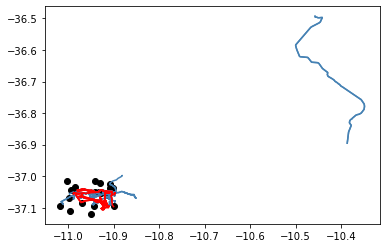

In [ ]:
a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

m = 20
Q = np.ones((m,2))

Q[:,0] = 0.2 * (b - a ) * np.random.random_sample(m) + a - 0.01
Q[:,1] = 0.2 *(d - c ) * np.random.random_sample(m) + c - 0.02

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");
plt.scatter(Q[:,0], Q[:,1], color = "black")
print(colored(f'Original car-bus', 'yellow'))
plt.show()

## Plot data

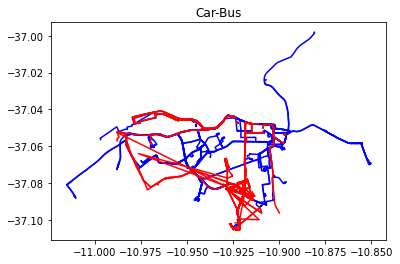

In [ ]:
for i in range(len(cars)):
    if i != 11 and i != 12:
        plt.plot(cars[i][:,0], cars[i][:,1], color='blue')
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color='red')
plt.title('Car-Bus')
plt.savefig(f'/Users/hasan/Desktop/Anaconda/Research/Pictures for 2ed paper/Car-Bus data.png', 
            bbox_inches='tight', dpi=200)
plt.show()

# Classifiers and get_mu function

In [ ]:
CC = [100, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clf = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clf]
keys = [item[1] for item in clf]

In [ ]:
def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

# |Q| = 20 (done)

## Classification with feature mappings $v_Q$, $v_Q^{\exp}$, $v_Q^{\varsigma}$ with 20 random landmarks, and endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification.py


### Boost($v_Q$), Boost($v_Q^{\varsigma}$), Boost($v_Q^{\exp}$) with epoch=50 and num_trials_maj=11

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, epoch=50, 
                                    num_trials_maj=11, classifiers=clf,
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 88.49389386177063
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1995      0.2827     0.0711
2  Gaussian SVM, C=100, gamma=auto       0.1092      0.1800     0.0596
3  Poly kernel SVM, C=10, deg=auto       0.3224      0.3535     0.0628
4                    Decision Tree       0.0000      0.1735     0.0538
5     RandomForestClassifier, n=50       0.0000      0.1568     0.0504
6                              KNN       0.1631      0.2497     0.0586
7              Logistic Regression       0.3614      0.3795     0.0076
test_errors: 
 [0.2827, 0.18, 0.3535, 0.1735, 0.1568, 0.2497, 0.3795]
std_test_errors: 
 [0.0711, 0.0596, 0.0628, 0.0538, 0.0504, 0.0586, 0.0076]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, 
                            epoch=50, num_trials_maj=11, classifiers=clf,
                            version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 134.0998752117157
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2434      0.4222     0.0604
2  Gaussian SVM, C=100, gamma=auto       0.0046      0.2173     0.0747
3  Poly kernel SVM, C=10, deg=auto       0.2092      0.3519     0.0417
4                    Decision Tree       0.0000      0.1811     0.0660
5     RandomForestClassifier, n=50       0.0000      0.1751     0.0557
6                              KNN       0.1711      0.3395     0.0924
7              Logistic Regression       0.3617      0.3795     0.0053
test_errors: 
 [0.4222, 0.2173, 0.3519, 0.1811, 0.1751, 0.3395, 0.3795]
std_test_errors: 
 [0.0604, 0.0747, 0.0417, 0.066, 0.0557, 0.0924, 0.0053]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, epoch=50, 
                                num_trials_maj=11, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 90.3855652809143
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1639      0.2276     0.0723
2  Gaussian SVM, C=100, gamma=auto       0.0513      0.1859     0.0594
3  Poly kernel SVM, C=10, deg=auto       0.1349      0.2119     0.0555
4                    Decision Tree       0.0019      0.1827     0.0470
5     RandomForestClassifier, n=50       0.0019      0.1659     0.0487
6                              KNN       0.1342      0.2265     0.0690
7              Logistic Regression       0.2571      0.2773     0.0474
test_errors: 
 [0.2276, 0.1859, 0.2119, 0.1827, 0.1659, 0.2265, 0.2773]
std_test_errors: 
 [0.0723, 0.0594, 0.0555, 0.047, 0.0487, 0.069, 0.0474]


### Rand $v_Q$, Rand $v_Q^{\varsigma}$, Rand $v_Q^{\exp}$ with epoch=50 and num_trials_maj=1

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 8.587740421295166
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2000      0.2832     0.0732
2  Gaussian SVM, C=100, gamma=auto       0.1080      0.2000     0.0510
3  Poly kernel SVM, C=10, deg=auto       0.3465      0.3724     0.0243
4                    Decision Tree       0.0000      0.2189     0.0667
5     RandomForestClassifier, n=50       0.0002      0.1778     0.0633
6                              KNN       0.1600      0.2643     0.0568
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.2832, 0.2, 0.3724, 0.2189, 0.1778, 0.2643, 0.3784]
std_test_errors: 
 [0.0732, 0.051, 0.0243, 0.0667, 0.0633, 0.0568, 0.0]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 12.78705906867981
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2827      0.4335     0.0764
2  Gaussian SVM, C=100, gamma=auto       0.0075      0.2389     0.0678
3  Poly kernel SVM, C=10, deg=auto       0.2243      0.3714     0.0526
4                    Decision Tree       0.0000      0.2130     0.0689
5     RandomForestClassifier, n=50       0.0000      0.1876     0.0588
6                              KNN       0.2195      0.3443     0.0837
7              Logistic Regression       0.3614      0.3805     0.0091
test_errors: 
 [0.4335, 0.2389, 0.3714, 0.213, 0.1876, 0.3443, 0.3805]
std_test_errors: 
 [0.0764, 0.0678, 0.0526, 0.0689, 0.0588, 0.0837, 0.0091]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, 
                    epoch=50, num_trials_maj=1, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 8.858188152313232
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2188      0.2686     0.0808
2  Gaussian SVM, C=100, gamma=auto       0.0672      0.2259     0.0787
3  Poly kernel SVM, C=10, deg=auto       0.1537      0.2330     0.0606
4                    Decision Tree       0.0019      0.2178     0.0750
5     RandomForestClassifier, n=50       0.0024      0.1914     0.0639
6                              KNN       0.1694      0.2476     0.0697
7              Logistic Regression       0.2571      0.2881     0.0613
test_errors: 
 [0.2686, 0.2259, 0.233, 0.2178, 0.1914, 0.2476, 0.2881]
std_test_errors: 
 [0.0808, 0.0787, 0.0606, 0.075, 0.0639, 0.0697, 0.0613]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=20, 
                                               epoch=50, num_trials_maj=1, 
                                               classifiers=clf, test_size=0.3)
A = classifs.endpoint_classification()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 5.086495399475098
Number of trials = 50
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.4046      0.4654     0.0695
2  Gaussian SVM, C=100, gamma=auto       0.1036      0.2119     0.0475
3  Poly kernel SVM, C=10, deg=auto       0.2299      0.2573     0.0387
4                    Decision Tree       0.0000      0.1897     0.0625
5     RandomForestClassifier, n=50       0.0002      0.1611     0.0611
6                              KNN       0.1655      0.2481     0.0556
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.4654, 0.2119, 0.2573, 0.1897, 0.1611, 0.2481, 0.3784]
std_test_errors: 
 [0.0695, 0.0475, 0.0387, 0.0625, 0.0611, 0.0556, 0.0]


# Classification with Perceptron-Like algorithm |Q|=20 (done)

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class.py


## Boost(MD $v_Q^{\exp}$) with epoch=50, maj_num=11 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT']:
    classif = classification(cars, buses, Q_size=20, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 1380.280268907547
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0554      0.1957     0.0581
mu = 0.012146736204842412
total time = 1446.7111554145813
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0354      0.1724     0.0628
mu = 0.006848675972413787


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 1447.7007174491882
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0349      0.1778     0.0541
mu = 0.01238757273484481
total time = 1432.961101770401
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1908     0.0578
mu = 0.00850207840025341


In [ ]:
for Model in ['RF', 'KNN', 'LR']:
    classif = classification(cars, buses, Q_size=20, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 4032.5735795497894
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.1546     0.0557
mu = 0.0032410886532936445
total time = 1485.8080697059631
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1195      0.2292     0.0649
mu = 0.016564986613522237
total time = 1469.1226093769073
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1906      0.2427     0.0427
mu = 0.010488417941083128


## MD $v_Q^{\exp}$ with epoch=50, maj_num=1 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(cars, buses, Q_size=20, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 123.03448677062988
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0836      0.2238     0.0688
mu = 0.01294077719865605
total time = 126.10394239425659
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0369      0.1762     0.0562
mu = 0.011605116339872268


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 128.62978982925415
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0361      0.1762     0.0647
mu = 0.010430293181144634
total time = 123.05035185813904
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2189     0.0699
mu = 0.020574124604911148
total time = 370.0476064682007
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50        0.001      0.1724     0.0639
mu = 0.011921934540580992
total time = 133.46698093414307
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1453       0.253     0.0644
mu = 0.010451424613391325
total time = 130.35126757621765
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2017      0.2573     0.0555
mu = 0.016327401768151617


# KNN with $d_Q^{\pi}$ (with |Q|=20) and DTW (done)

## KNN with $d_Q^{\pi}$ distance with matrix storing method  (|Q|=20)

### Calculate distance matrix

In [ ]:
def calculate_dists_d_Q_pi(data1, data2, p, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(d_Q_pi(Q, data[i], data[j], p=p))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44.csv'
calculate_dists_d_Q_pi(cars, buses, p=1, path=path)

10.94710373878479

In [ ]:
def KNN_with_dists_d_Q_pi(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error_d_Q_pi(data1, data2, num_trials, path_to_dists):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_d_Q_pi(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with d_Q_pi", 
                    np.round(np.mean(train_errors), decimals=4), 
                    np.round(np.mean(test_errors), decimals=4), 
                    np.round(np.std(test_errors), decimals=4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44.csv'
KNN_average_error_d_Q_pi(cars, buses, num_trials=50, path_to_dists=path)

num_trials = 50
total time = 0.9918913841247559


(        Classifier  Train Error  Test Error     std
 1  KNN with d_Q_pi       0.1566      0.2514  0.0636,
 0.15662650602409636,
 0.2513513513513514,
 0.06355662711516134)

## KNN with DTW from tslearn by saving matrx method

### Calculate distance matrix

In [ ]:
def calculate_dists_dtw_tslearn(data1, data2, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/dtw-tslearn-76-44.csv'
calculate_dists_dtw_tslearn(cars, buses, path=path)

6.181522607803345

In [ ]:
def KNN_with_dists_dtw_tslearn(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd-76-44.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists,  header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error_dtw_tslearn(data1, data2, num_trials, path_to_dists):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_dtw_tslearn(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with dtw from tslearn", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/dtw-tslearn-76-44.csv'

F = KNN_average_error_dtw_tslearn(cars, buses, num_trials=50, path_to_dists=path)
F[0]

num_trials = 50
total time = 1.005387783050537


,Classifier,Train Error,Test Error,std
1,KNN with dtw from tslearn,0.1694,0.2589,0.0682


# Using physical and geometric features together (done)

## Length, speed, acceleration and jerk functions

In [ ]:
# average speed from data
#A = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[1:,:]
A = read_file('GPS Trajectory/go_track_tracks.csv')[1:,:]

I = np.where(np.array(list(map(int, A[1:,-2]))) == 1)[0]
print(np.mean(list(map(float, A[I][:,2]))))

J = np.where(np.array(list(map(int, A[1:,-2]))) == 2)[0]
np.mean(list(map(float, A[J][:,2])))

18.19506994256931


15.220043103081029

In [ ]:
# length calculator 
def length(x):
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    Length = [sum(L)/len(L)]
    return Length

In [ ]:
# speed calculator 
def speed(x):
    t = x[:,2][1:] - x[:,2][:-1] + 1e-10
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    speeds = L/t
    s = [sum(speeds)/len(speeds)]
    return s

In [ ]:
# acceleration calculator
def acceleration(x):
    t = x[:,2][1:] - x[:,2][:-1] + 1e-10
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    accelerations = L/t**2
    a = [1e-5 * sum(accelerations)/len(accelerations)]
    return a

In [ ]:
# jerk calculator 
def jerk(x):
    t = x[:,2][1:] - x[:,2][:-1] + 1e-10
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    jerks = L/t**3
    a = [1e-5 * sum(jerks)/len(jerks)]
    return a

In [ ]:
def train_test(data1, data2, test_size):
    
    n_1 = len(data1)
    n_2 = len(data2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 = \
            train_test_split(np.arange(n_1), np.ones(n_1), test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 = \
    train_test_split(np.arange(n_2), -np.ones(n_2), test_size=test_size)
    
    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
            train_idx_2, test_idx_2, train_label_2, test_label_2

## Prepairing data to get physical features 

In [ ]:
# create 'daysDate' function to convert start and end time to a float number of days
from datetime import datetime
def days_date(time_str):
    date_format = "%Y-%m-%d %H:%M:%S"
    current = datetime.strptime(time_str, date_format)
    date_format = "%Y-%m-%d"
    bench = datetime.strptime('2006-12-30', date_format)
    no_days = current - bench
    delta_time_days = no_days.days + current.hour / 24.0 + current.minute / (24. * 60.) + current.second / (24. * 3600.)
    return delta_time_days

days_date = np.vectorize(days_date)
float1 = np.vectorize(float)

In [ ]:
#A = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')#[1:,:]
A = read_file('GPS Trajectory/go_track_tracks.csv')

print(A[:2])
#traj1 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_trackspoints.csv')[1:,1:5]
traj1 = read_file('GPS Trajectory/go_track_trackspoints.csv')[1:,1:5]
traj1[:, -1] = [traj1[:, -1][i][1:-1] for i in range(len(traj1))]
traj1[:, -1] = days_date(traj1[:, -1])
traj1 = float1(traj1)
traj1[:2]
# B is the data with time in last dimension

[['"id"' '"id_android"' '"speed"' '"time"' '"distance"' '"rating"'
  '"rating_bus"' '"rating_weather"' '"car_or_bus"' '"linha"']
 ['1' '0' '19.2105856218409' '0.138048888888889' '2.652' '3' '0' '0' '1'
  '""']]


array([[-1.09393414e+01, -3.70627421e+01,  1.00000000e+00,
         2.81430870e+03],
       [-1.09393414e+01, -3.70627421e+01,  1.00000000e+00,
         2.81430876e+03]])

In [ ]:
trajec1 = [0] * 163

for i in range(163):
    trajec1[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec1[i] = np.array([labels[i], traj1[:,[0,1,3]][I]], dtype='object')

trajec1 = np.array(trajec1)

trajectory1 = [0] * 163
trajectory_label_id_1 = [0] * 163

for i in range(163):
    trajectory1[i] = trajec1[i][1]
    trajectory_label_id_1[i] = np.array([trajec1[i][1], trajec1[i][0], 
                                         trajec1[i][1][0]], dtype='object')

trajectory_label_id_1 = np.array(trajectory_label_id_1, dtype='object')
trajectory1 = np.array(trajectory1, dtype='object')

min_length = 10
max_length = 1000 #160 for balance data
l = 0
index = [] 
for i in range(163):
    if len(trajectory1[i]) < min_length or len(trajectory1[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
l, 163-l

(40, 123)

In [ ]:
trajectories1 = [0] * (163-l)
trajectories_label_id_1 = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory1[i]) >= min_length and len(trajectory1[i]) <= max_length:
        trajectories1[j] = np.array(trajectory1[i])
        trajectories_label_id_1[j] = trajectory_label_id_1[i]
        j = j + 1

trajectories_label_id_1 = np.array(trajectories_label_id_1, dtype='object')
trajectories1 = np.array(trajectories1, dtype='object')

cars_time = trajectories_label_id_1[np.where(trajectories_label_id_1[:,1] == 1)][:,:2][:,0]
buses_time = trajectories_label_id_1[np.where(trajectories_label_id_1[:,1] == -1)][:,:2][:,0]
cars_time_copy = cars_time.copy()
buses_time_copy = buses_time.copy()
len(cars_time), len(buses_time)

(78, 45)

In [ ]:
a = np.arange(len(cars_time))
I = np.where((a != 28) & (a != 29))
cars_time = cars_time[I]
buses_time = buses_time[:-1]
len(cars_time), len(buses_time)

(76, 44)

In [ ]:
def remove_segments_time(traj): # removes stationary points
    p2 = traj[:,:2][1:]
    p1 = traj[:,:2][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

cars_time = np.array(list(map(remove_segments, cars_time)), dtype='object')
buses_time = np.array(list(map(remove_segments, buses_time)), dtype='object')

cars_time_copy = cars_time.copy()
buses_time_copy = buses_time.copy()
print("len(cars), len(buses)=", len(cars_time), len(buses_time))

len(cars), len(buses)= 76 44


## Classification with only physical features

In [ ]:
def get_features(data_1, data_2, Leng=True, spd=True, accn=True, jrk=True):

    data = np.concatenate((data_1, data_2), 0)
    n = len(data)
    data_traj_1 = np.array([data_1[i][:,:2] for i in range(len(data_1))])
    data_traj_2 = np.array([data_2[i][:,:2] for i in range(len(data_2))])
    data_traj = np.array([data[i][:,:2] for i in range(n)])
    data_labels = np.array([1] * len(data_1) + [-1] * len(data_2))
    A = data_labels.copy().reshape(-1,1)

    if Leng == True:
        length_ = np.array([length(data_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(data[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(data[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(data[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A[:, 1:]

In [ ]:
def classification_physical_features(data_1, data_2, epoch, classifiers, 
                                       Leng=True, spd=True, accn=True, jrk=True, 
                                       test_size=0.3):
    start_time = time.time()
    models = [item[0] for item in classifiers]
    keys = [item[1] for item in classifiers]
    r = len(classifiers)

    train_error_mean = np.ones(r)
    test_error_mean = np.ones(r)
    test_error_std = np.ones(r)
    
    train_errors = np.ones((r, epoch)) 
    test_errors = np.ones((r, epoch))

    data = get_features(data_1, data_2, Leng=Leng, spd=spd, accn=accn, jrk=jrk)
    data1 = data[:len(data_1)]
    data2 = data[len(data_1):]

    for s in range(epoch):
        train_idx_1, test_idx_1, train_labels_1, test_labels_1, \
            train_idx_2, test_idx_2, train_labels_2, test_labels_2 \
                = train_test(data1, data2, test_size=test_size)

        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]

        I = np.arange(len(train1)+len(train2))
        np.random.shuffle(I)
        J = np.arange(len(test1)+len(test2))
        np.random.shuffle(J)

        train = np.concatenate((train1, train2), 0)[I]
        test = np.concatenate((test1, test2), 0)[J]
        train_labels = np.concatenate((train_labels_1, train_labels_2), 0)[I]
        test_labels = np.concatenate((test_labels_1, test_labels_2), 0)[J]

        x_preds = np.zeros((r, len(train)))
        y_preds = np.zeros((r, len(test)))

        for k in range(r): 
            Model = models[k]
            Model.fit(train, train_labels)
            x_preds[k] = Model.predict(train)                
            y_preds[k] = Model.predict(test)

        for k in range(r):
            train_errors[k][s] = sum(train_labels != x_preds[k])/len(train_labels)
            test_errors[k][s] = sum(test_labels != y_preds[k])/len(test_labels)

    for k in range(r):
        train_error_mean[k] = np.mean(train_errors[k])
        test_error_mean[k] = np.mean(test_errors[k])
        test_error_std[k] = np.std(test_errors[k])

    Dict = {}

    for k in range(len(keys)): 
        Dict[k+1] = [keys[k], np.round(train_error_mean[k], decimals=4), 
                     np.round(test_error_mean[k], decimals=4),
                     np.round(test_error_std[k], decimals=4)]

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Classifier','Train Error', 'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf, train_error_mean, test_error_mean

In [ ]:
classification_physical_features(cars_time, buses_time, epoch=50, classifiers=clf, 
                                 Leng=True, spd=True, accn=True, jrk=True, 
                                 test_size=0.3)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  im

total time = 6.906736850738525


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 100",0.0263,0.0389,0.0347
2,"Gaussian SVM, C=100, gamma=auto",0.0424,0.0816,0.0420
3,"Poly kernel SVM, C=10, deg=auto",0.0424,0.0649,0.0320
4,Decision Tree,0.0000,0.0584,0.0372
5,"RandomForestClassifier, n=50",0.0000,0.0568,0.0330
6,KNN,0.0547,0.0870,0.0409
7,Logistic Regression,0.0345,0.0519,0.0370


## Classification with $v_Q^+$ which is random Q and physical features

In [ ]:
def get_features_Q(train_1, train_2, version='unsigned', sigma=1, Q_size=20, 
                   Leng=True, spd=True, accn=True, jrk=True):

    train = np.concatenate((train_1, train_2), 0)
    n = len(train)
    train_traj_1 = np.array([train_1[i][:,:2] for i in range(len(train_1))])
    train_traj_2 = np.array([train_2[i][:,:2] for i in range(len(train_2))])
    train_traj = np.array([train[i][:,:2] for i in range(n)])

    Mean = np.mean([np.mean(train_traj[i], 0) for i in range(n)], 0)
    Std = np.std([np.std(train_traj[i], 0) for i in range(n)], 0)
    Q = np.ones((Q_size,2))
    Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
    Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

    A = np.array(curve2vec(Q, train_traj, version=version, sigma=sigma))
    
    if Leng == True:
        length_ = np.array([length(train_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A, Q

In [ ]:
def get_test_data_Q(test_1, test_2, Q, version='unsigned', sigma=1, Leng=True, 
                    spd=True, accn=True, jrk=True):

    test = np.concatenate((test_1, test_2), 0)
    n = len(test)
    test_traj_1 = np.array([test_1[i][:,:2] for i in range(len(test_1))])
    test_traj_2 = np.array([test_2[i][:,:2] for i in range(len(test_2))])
    test_traj = np.array([test[i][:,:2] for i in range(n)])

    A = np.array(curve2vec(Q, test_traj, version=version, sigma=sigma))
    
    if Leng == True:
        length_ = np.array([length(test_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A

In [ ]:
def classification_Q_physics(data1, data2, version='unsigned', sigma=1, Q_size=20, 
                     Leng=True, spd=True, accn=True, jrk=True, num_trials=10, 
                     classifiers=clf):

    Start_time = time.time()
    models = [item[0] for item in classifiers]
    keys = [item[1] for item in classifiers]
    r = len(classifiers)
    train_error_mean = np.zeros(r)
    test_error_mean = np.zeros(r)
    test_error_std = np.zeros(r)
    train_error_list = np.zeros((r, num_trials)) 
    test_error_list = np.zeros((r, num_trials))

    for s in range(num_trials):

        train_idx_1, test_idx_1, train_labels_1, test_labels_1, \
            train_idx_2, test_idx_2, train_labels_2, test_labels_2 \
            = train_test(data1, data2, test_size=0.3)

        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]

        train, Q = get_features_Q(train1, train2, version, sigma,
                                  Q_size, Leng, spd, accn, jrk)
        #train = (train-np.mean(train,0))/np.std(train,0)
        train_labels = np.concatenate((train_labels_1, train_labels_2), 0)

        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]

        J = np.arange(len(test1)+len(test2))
        np.random.shuffle(J)

        test = get_test_data_Q(test1, test2, Q, version=version, sigma=sigma, 
                               Leng=Leng, spd=spd, accn=accn, jrk=jrk)[J]
        test_labels = np.concatenate((test_labels_1, test_labels_2), 0)[J]
        #test = (test-np.mean(test,0))/np.std(test,0)

        for k in range(r):            
            model = models[k]

            #Train the model using the training sets
            model.fit(train, train_labels)

            #Predict train labels
            train_pred = model.predict(train)
            err = sum(train_labels != train_pred)/len(train_labels)
            train_error_list[k][s] = err
            
            #Predict test labels
            test_pred = model.predict(test)
            er = sum(test_labels != test_pred)/len(test_labels)
            test_error_list[k][s] = er
            
    for k in range(r):
        train_error_mean[k] = np.mean(train_error_list[k])
        test_error_mean[k] = np.mean(test_error_list[k])
        test_error_std[k] = np.std(test_error_list[k])
    
    Dic = {}

    for k in range(len(keys)): 
        Dic[k] = [keys[k], np.round(train_error_mean[k], decimals = 4), 
                    np.round(test_error_mean[k], decimals = 4),
                    np.round(test_error_std[k], decimals = 4)]

    pdf = pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error', 'Std Error'])
    print(colored(f"Total time: {time.time() - Start_time}", 'red'))
    return pdf

### With only adding length

In [ ]:
classification_Q_physics(cars_time, buses_time, version='unsigned',  
                        Q_size=20, Leng=True, spd=False, accn=False, jrk=False, 
                        num_trials=50, classifiers=clf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

Total time: 8.915104866027832


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 100",0.2053,0.3016,0.0793
1,"Gaussian SVM, C=100, gamma=auto",0.0713,0.1632,0.0507
2,"Poly kernel SVM, C=10, deg=auto",0.3128,0.3454,0.0530
3,Decision Tree,0.0000,0.1703,0.0744
4,"RandomForestClassifier, n=50",0.0000,0.1503,0.0633
5,KNN,0.1627,0.2600,0.0684
6,Logistic Regression,0.3614,0.3795,0.0076


In [ ]:
#
classification_Q_physics(cars_time, buses_time, version='signed', sigma=1, 
                        Q_size=20, Leng=True, spd=False, accn=False, jrk=False, 
                        num_trials=50, classifiers=clf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

Total time: 13.180290222167969


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 100",0.2807,0.4189,0.0703
1,"Gaussian SVM, C=100, gamma=auto",0.0007,0.2124,0.0776
2,"Poly kernel SVM, C=10, deg=auto",0.1639,0.3114,0.0617
3,Decision Tree,0.0000,0.1978,0.0685
4,"RandomForestClassifier, n=50",0.0000,0.1432,0.0642
5,KNN,0.2236,0.3551,0.0776
6,Logistic Regression,0.3636,0.3778,0.0066


### With adding all physical pheatures

#### $v_Q^+$

In [ ]:
classification_Q_physics(cars_time, buses_time, version='unsigned',  
                         Q_size=20, Leng=True, spd=True, accn=True, jrk=True, 
                         num_trials=50, classifiers=clf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

Total time: 12.53266978263855


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 100",0.0224,0.0314,0.0317
1,"Gaussian SVM, C=100, gamma=auto",0.0311,0.0692,0.0496
2,"Poly kernel SVM, C=10, deg=auto",0.3046,0.3341,0.0737
3,Decision Tree,0.0000,0.0784,0.0440
4,"RandomForestClassifier, n=50",0.0000,0.0795,0.0440
5,KNN,0.0586,0.0773,0.0412
6,Logistic Regression,0.0267,0.0465,0.0367


#### $v_Q^{\varsigma +}$

In [ ]:
classification_Q_physics(cars_time, buses_time, version='signed', sigma=1, 
                        Q_size=20, Leng=True, spd=True, accn=True, jrk=True, 
                        num_trials=50, classifiers=clf)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

Total time: 16.498512744903564


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 100",0.0065,0.0195,0.0259
1,"Gaussian SVM, C=100, gamma=auto",0.0000,0.0638,0.0381
2,"Poly kernel SVM, C=10, deg=auto",0.0214,0.1141,0.0740
3,Decision Tree,0.0000,0.0730,0.0437
4,"RandomForestClassifier, n=50",0.0000,0.0530,0.0393
5,KNN,0.0535,0.0870,0.0460
6,Logistic Regression,0.0186,0.0384,0.0383


## Using Perceptron-like algorithm with physical features

In [ ]:
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec

def ExpCurve2Vec(points,curves,mu):
    D=tt.distsbase.DistsBase()
    return [np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves]

In [ ]:
def initialize_Q(train_1, train_2, C, gamma, Q_size, mu_coeff, model, Leng=True,
                 spd=True, accn=True, jrk=True, n_estimators=50):
    #Start_time = time.time()
    train = np.concatenate((train_1, train_2), 0)
    n = len(train)
    train_traj_1 = np.array([train_1[i][:,:2] for i in range(len(train_1))])
    train_traj_2 = np.array([train_2[i][:,:2] for i in range(len(train_2))])
    train_traj = np.array([train[i][:,:2] for i in range(n)])
    train_labels = np.array([1] * len(train_1) + [-1] * len(train_2))
    
    A = train_labels.copy().reshape(-1,1)
    if Leng == True:
        length_ = np.array([length(train_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    #print((A-np.mean(A,0))/np.std(A,0))

# Make the classifier
    if model == 'LSVM':
        Model = make_pipeline(LinearSVC(dual=False, C=C, tol=1e-5, 
                                        class_weight='balanced', max_iter=1000))
    elif model == 'GSVM':
        Model = make_pipeline(StandardScaler(), svm.SVC(C=C, kernel='rbf', 
                                                gamma=gamma, max_iter=200000))
    elif model == 'PSVM':
        Model = make_pipeline(StandardScaler(), svm.SVC(C=C, kernel='poly', 
                                                        degree=3, max_iter=400000))
    elif model == 'DT':
        Model = DecisionTreeClassifier()
    elif model == 'RF':
        Model = RandomForestClassifier(n_estimators=n_estimators)
    elif model == 'KNN':
        Model = KNeighborsClassifier(n_neighbors=5)
    elif model == 'LR':
        Model = LogisticRegression(solver='newton-cg')
    elif model == 'Prn':
        Model = Perceptron(tol=1e-5, validation_fraction=0.01, class_weight="balanced")
    else:
        print("model is not supported")
        
    mu = get_mu(train_traj_1, train_traj_2) * mu_coeff
    std = mu/2
    errors = []
    Q = []

    if sum([Leng, spd, accn, jrk]) > 0:
        Train_0 = A[:,1:]
        #Train_0 = (A[:,1:] - np.mean(A[:,1:] , 0))/np.std(A[:,1:],0)
        Model.fit(Train_0, train_labels)
        train_pred = Model.predict(Train_0) 
        error = 1 - metrics.accuracy_score(train_labels, train_pred)
        errors.append(error) 
        if model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
            index = np.argmax(np.max(Model.decision_function(Train_0)))
        else:
            probs = Model.predict_proba(Train_0)
            index = np.argmax(entropy(probs, axis=1))
    else:
        index = np.random.randint(0, high=n) 
    k = np.random.randint(0, high=len(train_traj[index]))
    q = train_traj[index][k] + np.random.normal(0, std, 2)
    Q.append(q)

# Iteratively choose landmarks
    for i in range(1, Q_size):
        if sum([Leng, spd, accn, jrk]) > 0:
            Train_0 = A[:,1:]
            Train = np.concatenate((Train_0, np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))), 1)
        else:
            Train = np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))

        Model.fit(Train, train_labels)
        train_pred = Model.predict(Train)
        error = 1 - metrics.accuracy_score(train_labels, train_pred)
        errors.append(error)
        if model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
            index = np.argmax(np.max(Model.decision_function(Train)))
        else:
            probs = Model.predict_proba(Train)
            index = np.argmax(entropy(probs, axis=1))

        k = np.random.randint(0, high=len(train_traj[index]))
        q = train_traj[index][k] + np.random.normal(0, std, 2)
        Q.append(q)
    if sum([Leng, spd, accn, jrk]) > 0:
        Train = np.concatenate((Train_0, np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))), 1)
    else: 
        Train = ExpCurve2Vec(np.array(Q), train_traj, mu)
    Model.fit(Train, train_labels)
    train_pred = Model.predict(Train)

    error = 1 - metrics.accuracy_score(train_labels, train_pred)
    errors.append(error)

    #print(colored(f"Total time for mapping row data: {time.time() - Start_time}", 'green'))

    return np.array(Q), mu, np.array(errors), error

In [ ]:
def train_test(data1, data2, test_size):
    
    n_1 = len(data1)
    n_2 = len(data2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 = \
            train_test_split(np.arange(n_1), np.ones(n_1), test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 = \
    train_test_split(np.arange(n_2), -np.ones(n_2), test_size=test_size)
    
    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
            train_idx_2, test_idx_2, train_label_2, test_label_2

In [ ]:
def classification_init_Q(data1, data2, C, gamma, Q_size, mu_coeff, model, epoch, 
                          init_iter, classifiers, Leng=True, spd=True, accn=True, 
                          jrk=True, test_size=0.3, normal=False, n_estimators=50):

    start_time = time.time()
    models = [item[0] for item in classifiers]
    keys = [item[1] for item in classifiers]

    r = len(classifiers)

    train_error_mean = np.zeros(r)
    test_error_mean = np.zeros(r)
    test_error_std = np.zeros(r)
    
    train_errors = np.zeros((r, epoch)) 
    test_errors = np.zeros((r, epoch))

    data = np.concatenate((data1, data2), 0)
    n1 = len(data1) 
    n2 = len(data2) 
    n = len(data) 
    data_traj1 = np.array([data1[i][:,:2] for i in range(len(data1))])
    data_traj2 = np.array([data2[i][:,:2] for i in range(len(data2))])
    data_traj = np.array([data[i][:,:2] for i in range(n)])
    labels = np.array([1] * len(data1) + [-1] * len(data2))
    #length1 = np.array([length(data_traj1[i]) for i in range(n1)])
    #length2 = np.array([length(data_traj2[i]) for i in range(n2)])

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, \
            train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test(data1, data2, test_size)
        
        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        train_traj1 = data_traj1[train_idx_1]
        train_traj2 = data_traj2[train_idx_2]
        train_labels1 = np.ones(len(train1))
        train_labels2 = np.zeros(len(train2))

        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]
        test_traj1 = data_traj1[test_idx_1]
        test_traj2 = data_traj2[test_idx_2]
        test_labels1 = np.ones(len(test1))
        test_labels2 = np.zeros(len(test2))

        train = np.concatenate((train1, train2), 0)
        test = np.concatenate((test1, test2), 0)
        train_traj = np.concatenate((train_traj1, train_traj2), 0)
        test_traj = np.concatenate((test_traj1, test_traj2), 0)
        train_labels = np.concatenate((train_labels1, train_labels2), 0)
        test_labels = np.concatenate((test_labels1, test_labels2), 0)

        x_preds = np.zeros((r, len(train)))
        y_preds = np.zeros((r, len(test)))

        Q_list = []
        temp_errors = []
        mu_list = []

        for j in range(init_iter):
            B = initialize_Q(train1, train2, C=C, gamma=gamma, Q_size=Q_size, 
                             mu_coeff=mu_coeff, model=model, Leng=Leng, spd=spd, 
                             accn=accn, jrk=jrk, n_estimators=n_estimators)
            Q_list.append(B[0])
            temp_errors.append(B[-1])
            mu_list.append(B[1])

        h = np.argmin(temp_errors)
        Q = Q_list[h]
        mu = mu_list[h]
        print("mu =", mu)
        if sum([Leng, spd, accn, jrk]) > 0:
            A = train_labels.copy().reshape(-1,1)
            B = test_labels.copy().reshape(-1,1)
            if Leng == True:
                length_train = np.array([length(train_traj[i]) for i in range(len(train))]).reshape(-1,1)
                A = np.concatenate((A, length_train),1)
                length_test = np.array([length(test_traj[i]) for i in range(len(test))]).reshape(-1,1)
                B = np.concatenate((B, length_test),1)
            if spd == True:
                speed_train = np.array([speed(train[i]) for i in range(len(train))]).reshape(-1,1)
                A = np.concatenate((A, speed_train),1)
                speed_test = np.array([speed(test[i]) for i in range(len(test))]).reshape(-1,1)
                B = np.concatenate((B, speed_test),1)
            if accn == True:
                acceleration_train = np.array([acceleration(train[i]) for i in range(len(train))]).reshape(-1,1)
                A = np.concatenate((A, acceleration_train),1)
                acceleration_test = np.array([acceleration(test[i]) for i in range(len(test))]).reshape(-1,1)
                B = np.concatenate((B, acceleration_test),1)
            if jrk == True:
                jerk_train = np.array([jerk(train[i]) for i in range(len(train))]).reshape(-1,1)
                A = np.concatenate((A, jerk_train),1)
                jerk_test = np.array([jerk(test[i]) for i in range(len(test))]).reshape(-1,1)
                B = np.concatenate((B, jerk_test),1)
            if normal == True:
                A[:,1:] = (A[:,1:] - np.mean(A[:,1:] , 0))/(np.std(A[:,1:],0) + 1e-10)
                B[:,1:] = (B[:,1:] - np.mean(B[:,1:] , 0))/(np.std(B[:,1:],0) + 1e-10)
            train_data = np.concatenate((A[:,1:], np.array(ExpCurve2Vec(Q, train_traj, mu))), 1)
            test_data = np.concatenate((B[:,1:], np.array(ExpCurve2Vec(Q, test_traj, mu))), 1)
            #train_data = (train_data - np.mean(train_data))/(np.std(train_data) + 1e-10)
            #test_data = (test_data - np.mean(test_data))/(np.std(test_data) + 1e-10)
        else:
            train_data = np.array(ExpCurve2Vec(Q, train_traj, mu))
            test_data = test_length, np.array(ExpCurve2Vec(Q, test_traj, mu))

        for k in range(r): 
            Model = models[k]
            Model.fit(train_data, train_labels)
            x_preds[k] = Model.predict(train_data)                
            y_preds[k] = Model.predict(test_data)

        for k in range(r):
            train_errors[k][s] = 1 - metrics.accuracy_score(train_labels, x_preds[k])
            test_errors[k][s] = 1 - metrics.accuracy_score(test_labels, y_preds[k])

    for k in range(r):
        train_error_mean[k] = np.mean(train_errors[k])
        test_error_mean[k] = np.mean(test_errors[k])
        test_error_std[k] = np.std(test_errors[k])

    Dict = {}

    for k in range(len(keys)): 
        Dict[k+1] = [keys[k], np.round(train_error_mean[k], decimals = 4), 
                     np.round(test_error_mean[k], decimals = 4),
                     np.round(test_error_std[k], decimals = 4)]

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Classifier','Train Error', 'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf, train_error_mean, test_error_mean

In [ ]:
C = 100

clf_L = [make_pipeline(LinearSVC(dual=False, C=C, tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C="+str(C)]

L = classification_init_Q(cars_time, buses_time, C=C, gamma=1, Q_size=20, 
                          mu_coeff=1, model='LSVM', epoch=50, init_iter=3, 
                          classifiers=[clf_L], Leng=True, spd=True, accn=True, 
                          jrk=True, test_size=0.3, normal=False)
L[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.01874225625076953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008428594380340826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01059051373704989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007153905305628427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017760340975824462


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014746929620983451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01887330171334689


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012097894734269588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0017328641181819648


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019801738752240894


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011787598056024251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017825586307006702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010477048958721369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0150409565496048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01734857069541107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017047291220556815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01717274580013317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015748123933192915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020193393035366825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0007000116560362812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02115749256727817


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008630628275064112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0010836322847893598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0049768400113006095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013836014328930446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010013384874707043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008698384204155474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0016096094702504615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01701598476697086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01971577489400289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014037310699670513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007713101218449481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.004795812520590914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012100020868462735


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021491478445728518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0010401084208595535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01789533033697488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.004469117226570063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009765409221897059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008848791634363806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02329098502638871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014588822455785078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013306323461847569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017428862605973094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017963601753841374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01719407371613002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008814976277434994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019771027078359538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0024872317971738056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01886748623580914
total time = 122.28410387039185


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C=100",0.0181,0.0259,0.0247


In [ ]:
C = 100
g = 'auto'
clf_GSVM = [make_pipeline(StandardScaler(), svm.SVC(C=C, kernel='rbf', gamma=g, 
                                                    max_iter=200000)),
                                    "GSVM, C="+str(C)+", gamma="+str(g)]

G = classification_init_Q(cars_time, buses_time, C=C, gamma=g, Q_size=20, 
                          mu_coeff=1, model='GSVM', epoch=50, init_iter=3, 
                          classifiers=[clf_GSVM], Leng=True, spd=True, 
                          accn=True, jrk=True, test_size=0.3, normal=False)
G[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.011901266161931545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010161139939114605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.000985791618056453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015598816001247684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016094137353608318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011285627644852525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0007266893212545256


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01924069698878661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015795458934254825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018142610747526433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008872404844474602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0206433715150105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007337380747795663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012104450417826484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017024718386469573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010335317353572293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00955319447645131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02013584379326261


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008821851862842678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02036690116571016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008164652207298673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021646567146824225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00987606499071525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011223330881826143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017960457142164543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01063127370688477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013929929065929159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.023500615033528405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022044543256582116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014852313011715523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016937972520903344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005159797750641459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010664027004237298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007100220423133408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00198996055040368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020977513357543387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016856166873530753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016023826658916107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.003762739952501093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01933015206973998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0249994898618926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.001874229154836371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008911398360746503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.006100507822750956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020369345945034922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01009141488837706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011046027008580594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01593723032276273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01787972029770124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016486456216663115
total time = 124.05608057975769


,Classifier,Train Error,Test Error,Std Error
1,"GSVM, C=100, gamma=auto",0.0373,0.0935,0.0481


In [ ]:
C = 1000
clf_PSVM = [make_pipeline(StandardScaler(), svm.SVC(C=C, kernel='poly', degree=5, 
                                                    max_iter=400000)),
            "Poly kernel SVM, C="+str(C)+", deg=auto"]

P = classification_init_Q(cars_time, buses_time, C=C, gamma=g, Q_size=20, 
                          mu_coeff=1, model='PSVM', epoch=50, init_iter=3, 
                          classifiers=[clf_PSVM], Leng=True, spd=True, 
                          accn=True, jrk=True, test_size=0.3, normal=False)
P[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.021414871108795808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01966488889110174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00918202165226667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00944506004139356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017948031749464022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01334216842226077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010585439567675436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.003251898271741993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020888109312563685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009680764966088162


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011917138928508209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011353355374584595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010288622304079453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009213952630640065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008399738848119398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021464336691840558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014712907750711324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008152944800425388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013055776238777739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0016380065341419225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01714053708068697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.028865743687601864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020018859640321907


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022810757837577356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019744898433238234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01039632222403064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015544461134728849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02463531300694477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.002056734457475784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.004305459528294975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005849793917152013


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009536021667898353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010019027748938925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01905642765499138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007040703924175773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020296302259115606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013041072689340183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016293900715698584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01748794627178185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008506023192552448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016032498168641496


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019829597689380307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0011994748179358083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02120646172382834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011992226974887998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019676794429113187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021467195148318297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018839148492372004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016670797458356645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00877341139659471
total time = 124.16497778892517


,Classifier,Train Error,Test Error,Std Error
1,"Poly kernel SVM, C=1000, deg=auto",0.052,0.1114,0.0852


In [ ]:
clf_DT = [DecisionTreeClassifier(), "Decision Tree"]

DT = classification_init_Q(cars_time, buses_time, C=1, gamma=1, Q_size=20, 
                          mu_coeff=1, model='DT', epoch=50, init_iter=3, 
                          classifiers=[clf_DT], Leng=True, spd=True, accn=True, 
                          jrk=True, test_size=0.3, normal=False)
DT[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.010990681188312479


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005204545710789432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014953482395414497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008418473608106325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.006363942437289438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005296818823465443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0008482334421113791


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009586067244981678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022847702513296042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007426677739804433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01641257536794427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012154608321191418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015288210288936455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020750877488257657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019441707910042183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01133255603264871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009994954118866417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014346376954961215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02197851307050236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008085030562469342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012413351022203756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008490412011191495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016748698541107387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01639317699228826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.001759287719032443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0033751705215223637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015090899359513799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010396972160679141


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009630425419141275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019343770664120186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016472172266514207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010584155327522993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007574227369822495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02100041874085612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017976498105808147


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021793957809022046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009154197077551274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.024383576055521772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012927808095616555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0049603385312870785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011037622915008427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009403719939090394


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008618068183366745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01839271425640021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015476200469818124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007240827926006332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01583350471938516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008021485900272296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017873429482291314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0014024821707536717
total time = 120.62204122543335


,Classifier,Train Error,Test Error,Std Error
1,Decision Tree,0.0,0.067,0.0372


In [ ]:
n_estimators = 50

clf_RF = [RandomForestClassifier(n_estimators=n_estimators), 
         "RandomForestClassifier, n="+str(n_estimators)]

RF = classification_init_Q(cars_time, buses_time, C=1, gamma=1, Q_size=20, 
                          mu_coeff=1, model='RF', epoch=50, init_iter=3, 
                          classifiers=[clf_RF], Leng=True, spd=True, accn=True, 
                          jrk=True, test_size=0.3, normal=False, 
                           n_estimators=n_estimators)
RF[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.010388859323043675


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017108432188539524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01013691136859407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015884914455480015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016956395309414063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02253938856054205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016006016965397052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022350512429120784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.003477891564642732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01025155442735226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016112630074751166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018907573142502798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01954836414199157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0030355794421996762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009466846211966029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021641914346384183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014430583359008153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011587467031798582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01822363246597014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007756704089572963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.013491704709705843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01578213973855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019436656220555903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017675800805672992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010317567938706418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017812855679999018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010754486365355476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008265669296108058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009531227130377573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008175259889652509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009572111381762838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008280119259524099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010247586895486549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005964796100627723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010125918601696426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018401441072272817


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012816352076637116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00716021611055595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016295279838942633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01839412827629161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012620830281603546


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020164508034442363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018960809030842185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012132630399708688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016869775709336565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009778625894483639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00914055537739955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016974728398123418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0036945853254994887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015204034747327455
total time = 367.5573043823242


,Classifier,Train Error,Test Error,Std Error
1,"RandomForestClassifier, n=50",0.0,0.0897,0.0447


In [ ]:
n_neighbors = 5

clf_KNN = [KNeighborsClassifier(n_neighbors=n_neighbors), "KNN"]

K = classification_init_Q(cars_time, buses_time, C=1, gamma=1, Q_size=20, 
                          mu_coeff=1, model='KNN', epoch=50, init_iter=3, 
                          classifiers=[clf_KNN], Leng=True, spd=True, accn=True, 
                          jrk=True, test_size=0.3, normal=False)
K[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.0017962169454950327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01849835860091531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010203325938883623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.005582748616880906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007177102561076509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01874456920445766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014372567711951945


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008964678954484384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0069509425392251245


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007873414685068525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010283453535549825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022166671027582296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01518120117810895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022773411373409047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020692196919727124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010102969640072956


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009677590717796392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01818751743241087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007909512446538258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01575941728776087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0026563777452111026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010216111303863684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01983528685481417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01554856115978609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022436984799831805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010428430342606987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019272234116796128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022679235536669395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00627590594639571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01725332371558963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007594973319569931


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018301731067202454


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017081778817697568


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0065279660756054625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011858064309473448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017580106868669176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.022553488354473572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012637826307720701


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021663600376852443


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011119573830438156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0025010869989454676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01598940998047027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.003420494109704464


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017616568045397685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018662625680184064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008531447170753381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.007936419527053928


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009082431755373932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011458232560135784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012334068125205988
total time = 134.09177255630493


,Classifier,Train Error,Test Error,Std Error
1,KNN,0.0559,0.0832,0.0445


In [ ]:
clf_LR = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

LR = classification_init_Q(cars_time, buses_time, C=100, gamma=1, Q_size=20, 
                          mu_coeff=1, model='LR', epoch=50, init_iter=3, 
                          classifiers=[clf_LR], Leng=True, spd=True, 
                          accn=True, jrk=True, test_size=0.3, normal=False)
LR[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local

mu = 0.0023304056470934142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017665395540054973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019774692348876854


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.004149119209472474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.011996057033291763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018597610577849366


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.021916264143609254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.016979508516238084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008737166040573285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.014126860756887183


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015623568725933623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01244241199978724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009489291671430422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008537825766261165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.020186589574921143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009819392077188738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0006670116048326236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01764415086708304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01930822491901374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.00651596792627096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01970643411117834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.018307122741727966


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010069514322925244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017111583131958596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02117721578435372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02202841680976242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015823217591441008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010026144941829074


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.015649934900086038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02343044334433131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.02237214149725375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.008199207608152292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.024642281387995624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01716317821222546


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.017700604391043484


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.002626840768378713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019066440665667983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01795463103601236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.003242033547980583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009428121322949679


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009452536281276736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.019735863159871414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01846179370830292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0072744006698748365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.010689659315266553


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.0019219202760680787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01465417896779364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.01763258413422797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.012708384871462641


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

mu = 0.009909050629168803
total time = 266.0726988315582


,Classifier,Train Error,Test Error,Std Error
1,Logistic Regression,0.0183,0.0432,0.0394


# Run time Analysis (done)

## $v_Q$, $v_Q^{\varsigma}$, $v_Q^{\exp}$, endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification_runtime
from v_Q_mu_endpoints_classification_runtime import runTime

Saving v_Q_mu_endpoints_classification_runtime.py to v_Q_mu_endpoints_classification_runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
import timeit



def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


'''The following class includes 3 functions:
        1. According to v_Q classification (classification_v_Q() function)
            a) Average
            b) Average-Majority
        2. According to v_Q^mu classification (classification_v_Q_mu() function)
            a) Average
            b) Average-Majority
        3. Endpoint classification (endpoint_classification() function)
            a) Only average'''

class runTime():
    def __init__(self, data_1, data_2, Q_size, classifiers, std_coeff=1, version='unsigned', sigma=1):
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.classifiers = classifiers
        self.version = version
        self.sigma = sigma
        self.std_coeff = std_coeff

    
        
    '''mu calculator function'''
        
    def get_mu(self, data_1, data_2):
        a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
        b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
        return max(abs(a-b)) * self.std_coeff


    def generate_Q_runtime(self):

        start_time = time.time()
        data = np.concatenate((self.data_1, self.data_2), 0)

        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)

        Q = np.ones((self.Q_size, 2))
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

        stop_time = time.time()
        total_time = stop_time - start_time

        return total_time


    def train_classifier_v_Q_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = curve2vec(Q, data, version=self.version, sigma=self.sigma)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime


    def train_classifier_v_Q_exp_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            mu = self.get_mu(self.data_1, self.data_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = ExpCurve2Vec(Q, data, mu)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

    '''Get the endpoints of all trajectories in data_1 and data_2'''
    def get_endpoints(self):
        n_1 = len(self.data_1)
        n_2 = len(self.data_2)
        data_1_endpoints = np.zeros((n_1, 4))
        data_2_endpoints = np.zeros((n_2, 4))
        for i in range(n_1):
            data_1_endpoints[i] = np.concatenate((self.data_1[i][0], self.data_1[i][-1]), 0)
        for i in range(n_2):
            data_2_endpoints[i] = np.concatenate((self.data_2[i][0], self.data_2[i][-1]), 0)
        return data_1_endpoints, data_2_endpoints
        

    '''Get the endpoint classification error
       parameters: 
            1. data_1, data_2
            2. epoch
            3. classifiers'''
    def train_classifier_endpoint_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]
        r = len(self.classifiers)
        train_runtime = np.zeros(r)
        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 

        data_1_endpoints, data_2_endpoints = self.get_endpoints()
        Data = np.concatenate((data_1_endpoints, data_2_endpoints), 0)
        labels = np.array([1]*n_1 + [-1]*n_2)

        for k in range(r):
            time_temp = time.time()
            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time()
            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

## Runtime of initializing random landmarks with different classifiers

In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.generate_Q_runtime()
print(A)
print(colored(f'runtimes for generating random Q: {A}', 'yellow'))

The slowest run took 7.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 865 ns per loop
0.005908012390136719
runtimes for generating random Q: 0.005908012390136719


## Runtime of training classifiers

In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 8.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 931 ns per loop
run time: 0.5645260810852051
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.075171
2  Gaussian SVM, C=100, gamma=auto  0.071362
3  Poly kernel SVM, C=10, deg=auto  0.072181
4                    Decision Tree  0.067894
5     RandomForestClassifier, n=50  0.138942
6                              KNN  0.066300
7              Logistic Regression  0.072640
runtimes for v_Q: [0.07517051696777344, 0.07136178016662598, 0.07218146324157715, 0.06789374351501465, 0.13894176483154297, 0.0662999153137207, 0.07264018058776855]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='signed', sigma=1)
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='signed', sigma=1)
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^varsigma: {list(A[1])}', 'yellow'))

The slowest run took 7.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 972 ns per loop
run time: 1.1357877254486084
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.156448
2  Gaussian SVM, C=100, gamma=auto  0.154710
3  Poly kernel SVM, C=10, deg=auto  0.155463
4                    Decision Tree  0.155574
5     RandomForestClassifier, n=50  0.217628
6                              KNN  0.146808
7              Logistic Regression  0.149124
runtimes for v_Q^varsigma: [0.1564476490020752, 0.1547098159790039, 0.15546274185180664, 0.15557384490966797, 0.21762800216674805, 0.14680790901184082, 0.1491241455078125]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf, version='unsigned')
A = Runtime.train_classifier_v_Q_exp_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^exp: {list(A[1])}', 'yellow'))

The slowest run took 8.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 926 ns per loop
run time: 0.5967295169830322
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.076997
2  Gaussian SVM, C=100, gamma=auto  0.078820
3  Poly kernel SVM, C=10, deg=auto  0.076455
4                    Decision Tree  0.076720
5     RandomForestClassifier, n=50  0.143053
6                              KNN  0.071472
7              Logistic Regression  0.073178
runtimes for v_Q^exp: [0.07699728012084961, 0.07881975173950195, 0.07645487785339355, 0.07671999931335449, 0.1430530548095703, 0.07147216796875, 0.07317781448364258]


In [ ]:
%timeit runTime(cars, buses, Q_size=20, classifiers=clf)
Runtime = runTime(cars, buses, Q_size=20, classifiers=clf)
A = Runtime.train_classifier_endpoint_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 10.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 881 ns per loop
run time: 0.08534502983093262
                        Classifier   Runtime
1          SVM, LinearSVC, C = 100  0.001128
2  Gaussian SVM, C=100, gamma=auto  0.001843
3  Poly kernel SVM, C=10, deg=auto  0.001349
4                    Decision Tree  0.000556
5     RandomForestClassifier, n=50  0.069502
6                              KNN  0.000421
7              Logistic Regression  0.009215
runtimes for v_Q: [0.0011284351348876953, 0.0018427371978759766, 0.0013494491577148438, 0.0005559921264648438, 0.06950187683105469, 0.0004210472106933594, 0.009215354919433594]


## Mistake-driven

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Runtime
from Perceptron_Like_Algo_Runtime import runTimeMD

Saving Perceptron_Like_Algo_Runtime.py to Perceptron_Like_Algo_Runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
from scipy.stats import entropy




def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


# models = ['LSVM', 'GSVM', 'PSVM', 'LR', 'PERN', 'DT', 'RF', 'KNN']

class runTimeMD:
    def __init__(self, data_1, data_2, Q_size, model, C, gamma, std_coeff, 
                 n_neighbors, n_estimators):
        
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.model = model
        self.C = C
        self.gamma = gamma
        self.std_coeff = std_coeff
        self.n_neighbors = n_neighbors
        self.n_estimators = n_estimators
        
        
    
        
    '''mu calculator function'''
        
    def get_mu(self):
        a = np.mean([np.mean(self.data_1[i], 0) for i in range(len(self.data_1))], 0)
        b = np.mean([np.mean(self.data_2[i], 0) for i in range(len(self.data_2))], 0)
        return max(abs(a-b)) * self.std_coeff
       
        
    '''Perceptron-Like Algorithm'''
        
    def initialize_Q(self): 
        
        Q = []        

        mu = self.get_mu()
        std = mu * self.std_coeff

        trajectory_train_data = np.concatenate((self.data_1, self.data_2), axis = 0)
        train_labels = np.concatenate(([1] * len(self.data_1), [-1] * len(self.data_2)), 0)
        index = np.random.randint(0, high=len(trajectory_train_data)) 
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)
        
        if self.model == "LSVM":
            clf = make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                        class_weight='balanced', max_iter=1000))
        elif self.model == "GSVM":
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                gamma=self.gamma, max_iter=200000))
        elif self.model == 'PSVM':
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                    degree=3, max_iter = 400000))
        elif self.model == "LR":
            clf = LogisticRegression(solver='lbfgs')
        elif self.model == "Prn":
            clf = Perceptron(tol=1e-5, validation_fraction=0.01, class_weight="balanced")
        elif self.model == "DT":
            clf = DecisionTreeClassifier()
        elif self.model == "RF":
            clf = RandomForestClassifier(n_estimators=self.n_estimators)
        elif self.model == "KNN":
            clf = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        else:
            print("error: model is not supported")
        
        for i in range(self.Q_size):
            train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
            clf.fit(train_data, train_labels)

            train_pred = clf.predict(train_data)
            error = sum(train_labels != train_pred)/len(train_labels)
            
            if self.model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
                temp = train_labels * clf.decision_function(train_data)
                index = np.argmin(temp)
            elif self.model in ['DT', 'RF', 'KNN']:
                probs = clf.predict_proba(train_data)
                index = np.argmax(entropy(probs, axis=1))
            
            k = np.random.randint(0, high=len(trajectory_train_data[index]))
            q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
            Q.append(q)
        
        return np.array(Q), mu



    
    def train_classifier_runtime_Q(self):

        if self.model == 'LSVM':
            clf_L = [make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                       class_weight ='balanced', max_iter=1000)), 
                    "SVM, Linear SVC, C="+str(self.C)]
            clf = clf_L[0] 
        elif self.model == 'GSVM':
            clf_rbf = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                    gamma=self.gamma, max_iter=200000)), 
                       "GSVM, C="+str(self.C)+", gamma="+str(self.gamma)]
            clf = clf_rbf[0]
        elif self.model == 'PSVM':
            clf_PSVM = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                        degree=3, max_iter = 400000)),
                        "Poly kernel SVM, C="+str(self.C)+", deg=auto"]
            clf = clf_PSVM[0]
        elif self.model == "LR":
            clf_LR = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]
            clf = clf_LR[0]
        elif self.model == "Prn":
            clf_Prn = [Perceptron(tol=1e-5, validation_fraction=0.01, 
                               class_weight="balanced"), "Perceptron"]
            clf = clf_Prn [0]
        elif self.model == "DT":
            clf_DT = [DecisionTreeClassifier(), "Decision Tree"]
            clf = clf_DT[0]
        elif self.model == "RF":
            clf_RF = [RandomForestClassifier(n_estimators=self.n_estimators), 
                             "RandomForestClassifier, n="+str(self.n_estimators)]
            clf = clf_RF[0]
        elif self.model == "KNN":
            clf_KNN = [KNeighborsClassifier(n_neighbors=self.n_neighbors), "KNN"]
            clf = clf_KNN[0]
        else:
            print('model is not supported')

        start_time = time.time()

        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 
        data = np.concatenate((self.data_1, self.data_2), axis = 0)
        labels = np.array([1]*n_1 + [-1]*n_2)
        
        I = np.arange(len(data))
        np.random.shuffle(I)
        data = data[I]
        labels = labels[I]

        init_Q_strat_time = time.time()
        B = self.initialize_Q()
        init_Q_end_time = time.time()
        init_total_time = init_Q_end_time - init_Q_strat_time
        
        Q = B[0]
        mu = B[1]
        Data = ExpCurve2Vec(Q, data, mu)
        clf.fit(Data, labels)

        train_runtime = time.time() - start_time

        return train_runtime, init_total_time


## Runtime of training classifiers

In [ ]:
model = 'LSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.80 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.21 µs per loop
runtimes for initializing 20 landmarks with LSVM: 1.2072
runtimes for LSVM: 1.2842


In [ ]:
model = 'GSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.76 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with GSVM: 1.2567
runtimes for GSVM: 1.3335


In [ ]:
model = 'PSVM'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


runtimes for initializing 20 landmarks with PSVM: 1.5273
runtimes for PSVM: 1.6011


In [ ]:
model = 'DT'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 8.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with DT: 1.2087
runtimes for DT: 1.2819


In [ ]:
model = 'RF'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 9.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with RF: 2.9791
runtimes for RF: 3.1383


In [ ]:
model = 'KNN'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.35 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with KNN: 1.317
runtimes for KNN: 1.3901


In [ ]:
model = 'LR'
%timeit runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', \
                  std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(cars, buses, Q_size=20, model=model, C=100, gamma='auto', 
                    std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.21 µs per loop
runtimes for initializing 20 landmarks with LR: 1.2923
runtimes for LR: 1.3729


## KNN runtime

### install package

In [ ]:
# to make a directory
%cd 'gdrive/My Drive/traj-dist'

/content/gdrive/My Drive/traj-dist


In [ ]:
# to see in what directory we are in

In [ ]:
pwd

'/content/gdrive/My Drive/traj-dist'

In [ ]:
# to install setup.py from the current directory
!python setup.py install

In [ ]:
!pip install geohash2

In [ ]:
pip install fastdtw

In [ ]:
pip install tslearn

### KNN runtimes

In [ ]:
from google.colab import files
files.upload()

import KNN_Class_Colab_runtime
from KNN_Class_Colab_runtime import KNN_runTime

Saving KNN_Class_Colab_runtime.py to KNN_Class_Colab_runtime (1).py


In [ ]:
'''This class handles all the metrics in "metrics array bellow" and is appropriate for using in Anaconda 
   for example, but not on Google Colab.'''

'''Requirements: (These are already installed in my computer)
        1. We need "pip install trjtrypy" in order to be able to use d_Q_pi
        2. We need "pip install tslearn" in order to be able to use dtw
        3. We need "pip install fastdtw" in order to be able to use fastdtw
        4. We need "pip install traj_dist" in order to be able to use the rest of metrics'''


import numpy as np
import time
import pandas as pd
import random
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from termcolor import colored

#metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss',  
#           fastdtw, dtw, d_Q_pi]

# path example: 
#'Calculated Distance Matrices for KNN/Beijing-Pairs['+str(pairs_final[i])+']-d_Q_pi.csv'


class KNN_runTime:
    
    def __init__(self, data1, data2, metric, gamma=None, eps_edr=None, eps_lcss=None, 
                 Q_size=None, Q=None, p=2, n_neighbors=5, pair=None):
        '''data1 = data[pair[0]]
           data2 = data[pair[1]]'''
        self.data1 = data1
        self.data2 = data2
        self.metric = metric
        self.gamma = gamma
        self.eps_edr = eps_edr
        self.eps_lcss = eps_lcss
        self.Q_size = Q_size
        self.Q = Q
        self.p = p
        self.n_neighbors = n_neighbors
        self.pair = pair
    



    def calculate_dists_matrix(self):

        data = np.concatenate((self.data1, self.data2), 0)
        n = len(data)

        if self.metric == 'lcss':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_lcss)
        if self.metric == 'edr':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_edr)
        if self.metric in ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp']: 
            A = tdist.pdist(data, str(self.metric))
        if self.metric == fastdtw: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j])[0])
        if self.metric == dtw_tslearn: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j]))
        if self.metric == 'd_Q_pi':
            A = []
            if self.Q_size:
                Q = self.generate_random_Q()
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(Q, data[i], data[j], p=self.p))
            elif len(self.Q):
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(self.Q, data[i], data[j], p=self.p))

        tri = np.zeros((n, n))
        tri[np.triu_indices(n, 1)] = np.array(A)
        for i in range(1, n):
            for j in range(i):
                tri[i][j] = tri[j][i]
                
        return tri





    '''The following function is only used for d_Q_pi distance in order to 
       generate random landmarks
       Notice: in this pattern of coding we cannot use train1 and train2 to 
       get Q in the following function.'''
    def generate_random_Q(self):
        Q = np.zeros((self.Q_size, 2))
        data = np.concatenate((self.data1, self.data2), 0)
        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)
        return Q




    def KNN_runtime(self):
        
        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2) 
        
        labels = np.array([1] * n_1 + [-1] * n_2)
        data = np.concatenate((self.data1, self.data2), 0)
        dist_matrix = self.calculate_dists_matrix()

        clf = KNeighborsClassifier(n_neighbors=self.n_neighbors, metric='precomputed')
        clf.fit(dist_matrix, list(labels))
        stop_time = time.time()
        runtime = stop_time - start_time

        return runtime
    

In [ ]:
metrics = ['discret_frechet', 'hausdorff', dtw_tslearn, fastdtw, 'lcss', 'sspd',
           'edr', 'erp', 'd_Q_pi']
runtimes = []
for metric in metrics:
    %timeit KNN_runTime(cars, buses, metric=metric, gamma=None, eps_edr=0.02, \
                        eps_lcss=0.02, Q_size=20, Q=None, p=2, n_neighbors=5, pair=[0,1])

    Runtime = KNN_runTime(cars, buses, metric=metric, gamma=None, eps_edr=0.02, 
                      eps_lcss=0.02, Q_size=20, Q=None, p=2, n_neighbors=5, pair=[0,1])
    a = Runtime.KNN_runtime()
    runtimes.append(a)
    print(colored(f'runtimes for {metric}: {a}', 'yellow'))
    print(colored("===============================================================", 'red'))

print(colored(runtimes, 'blue'))

The slowest run took 10.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.46 µs per loop
runtimes for discret_frechet: 13.888860702514648
The slowest run took 5.12 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.46 µs per loop
runtimes for hausdorff: 7.758051633834839
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.48 µs per loop
runtimes for <function dtw at 0x7f115f76b5f0>: 6.160368919372559
The slowest run took 5.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.49 µs per loop
runtimes for <built-in function fastdtw>: 1.5054645538330078
The slowest run took 5.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best 

/usr/local/lib/python3.7/dist-packages/traj_dist-1.1-py3.7-linux-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


runtimes for erp: 45.32779359817505
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.45 µs per loop
runtimes for d_Q_pi: 10.646199941635132
[13.888860702514648, 7.758051633834839, 6.160368919372559, 1.5054645538330078, 14.494276523590088, 7.809615850448608, 15.586239337921143, 45.32779359817505, 10.646199941635132]


### KNN_LSH

In [ ]:
from google.colab import files
files.upload()

import KNN_with_LSH_runtime
from KNN_with_LSH_runtime import KNN_LSH_runTime

Saving KNN_with_LSH_runtime.py to KNN_with_LSH_runtime (1).py


In [ ]:
# pip install trjtrypy

'''A clss for KNN with LSH distance with random circles in each iteration'''

import numpy as np 
import time
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.basedists import distance
from termcolor import colored




class KNN_LSH_runTime:
    def __init__(self, data1, data2, number_circles):
        self.data1 = data1
        self.data2 = data2
        self.number_circles = number_circles



    def get_circles(self):

        data = np.concatenate((self.data1, self.data2,), 0)
        n = len(data)
        Mean = np.mean([np.mean(data[i], 0) for i in range(n)], 0)
        Std = np.std([np.std(data[i], 0) for i in range(n)], 0)
        circles_centers = np.ones((self.number_circles,2))
        circles_centers[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.number_circles)
        circles_centers[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.number_circles)

        return circles_centers



    def get_radius(self):

        a = np.mean([np.mean(self.data1[i], 0) for i in range(len(self.data1))], 0)
        b = np.mean([np.mean(self.data2[i], 0) for i in range(len(self.data2))], 0)

        return max(abs(a-b))



    def LSH_sketch(self):

        radius = self.get_radius()
        #print("radius =", radius)
        data = np.concatenate((self.data1, self.data2), 0)
        circles_centers = self.get_circles()
        dists = distance(circles_centers, data) # shape = len(data) x number_circles
        LSH_array = np.zeros((len(data), self.number_circles))
        circules_cut_idx = np.where(dists < radius)
        LSH_array[circules_cut_idx] = 1

        return LSH_array


    def calculate_LSH_dists(self):

        LSH_array = self.LSH_sketch()
        data = np.concatenate((self.data1, self.data2), 0)
        dists = np.zeros((len(data), len(data)))
        for i in range(len(data)-1):
            dists[i, i+1:] = np.sum(abs(LSH_array[i+1:] - LSH_array[i]), 1)
        for i in range(len(data)-1):
            for j in range(i+1, len(data)):
                dists[j][i] = dists[i][j]
        
        return dists



    def KNN_LSH_runtime(self):

        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2)

        radius = self.get_radius()
        dist_matrix = self.calculate_LSH_dists()

        labels = np.array([1]*n_1 + [-1] * n_2)

        clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        clf.fit(dist_matrix, list(labels))

        stop_time = time.time()
        runtime = stop_time - start_time
        
        return runtime


In [ ]:
%timeit KNN_LSH = KNN_LSH_runTime(cars, buses, number_circles=20)

KNN_LSH = KNN_LSH_runTime(cars, buses, number_circles=20)
t = KNN_LSH.KNN_LSH_runtime()
print(colored(f'runtime for KNN with LSH is: {t}', 'yellow'))

The slowest run took 12.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 573 ns per loop
runtime for KNN with LSH is: 0.08276605606079102


# |Q|=10 (done)

## Classification with feature mappings $v_Q$, $v_Q^{\exp}$, $v_Q^{\varsigma}$ with 10 random landmarks, and endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification (1).py


### Boost($v_Q$), Boost($v_Q^{\varsigma}$), Boost($v_Q^{\exp}$) with epoch=50 and num_trials_maj=11

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, epoch=50, 
                                    num_trials_maj=11, classifiers=clf,
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 125.98894500732422
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2516      0.3157     0.1013
2  Gaussian SVM, C=100, gamma=auto       0.1123      0.1778     0.0577
3  Poly kernel SVM, C=10, deg=auto       0.3402      0.3681     0.0354
4                    Decision Tree       0.0000      0.1768     0.0588
5     RandomForestClassifier, n=50       0.0000      0.1622     0.0575
6                              KNN       0.1578      0.2357     0.0587
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.3157, 0.1778, 0.3681, 0.1768, 0.1622, 0.2357, 0.3784]
std_test_errors: 
 [0.1013, 0.0577, 0.0354, 0.0588, 0.0575, 0.0587, 0.0]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, 
                            epoch=50, num_trials_maj=11, classifiers=clf,
                            version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 112.56549620628357
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3198      0.4124     0.0721
2  Gaussian SVM, C=100, gamma=auto       0.0055      0.1886     0.0627
3  Poly kernel SVM, C=10, deg=auto       0.2494      0.3486     0.0433
4                    Decision Tree       0.0000      0.1692     0.0532
5     RandomForestClassifier, n=50       0.0000      0.1578     0.0576
6                              KNN       0.1463      0.2984     0.0642
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.4124, 0.1886, 0.3486, 0.1692, 0.1578, 0.2984, 0.3784]
std_test_errors: 
 [0.0721, 0.0627, 0.0433, 0.0532, 0.0576, 0.0642, 0.0]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, epoch=50, 
                                num_trials_maj=11, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 88.36075735092163
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1969      0.2524     0.0797
2  Gaussian SVM, C=100, gamma=auto       0.0860      0.2130     0.0618
3  Poly kernel SVM, C=10, deg=auto       0.1790      0.2611     0.0586
4                    Decision Tree       0.0111      0.1865     0.0720
5     RandomForestClassifier, n=50       0.0118      0.1784     0.0626
6                              KNN       0.1335      0.2319     0.0585
7              Logistic Regression       0.3202      0.3459     0.0442
test_errors: 
 [0.2524, 0.213, 0.2611, 0.1865, 0.1784, 0.2319, 0.3459]
std_test_errors: 
 [0.0797, 0.0618, 0.0586, 0.072, 0.0626, 0.0585, 0.0442]


### Rand $v_Q$, Rand $v_Q^{\varsigma}$, Rand $v_Q^{\exp}$ with epoch=50 and num_trials_maj=1

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 8.080577850341797
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2716      0.3265     0.0883
2  Gaussian SVM, C=100, gamma=auto       0.1347      0.2043     0.0658
3  Poly kernel SVM, C=10, deg=auto       0.3410      0.3670     0.0412
4                    Decision Tree       0.0000      0.2070     0.0639
5     RandomForestClassifier, n=50       0.0002      0.1654     0.0601
6                              KNN       0.1634      0.2368     0.0636
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.3265, 0.2043, 0.367, 0.207, 0.1654, 0.2368, 0.3784]
std_test_errors: 
 [0.0883, 0.0658, 0.0412, 0.0639, 0.0601, 0.0636, 0.0]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 10.457443237304688
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3390      0.4297     0.0676
2  Gaussian SVM, C=100, gamma=auto       0.0190      0.2297     0.0742
3  Poly kernel SVM, C=10, deg=auto       0.2463      0.3822     0.0644
4                    Decision Tree       0.0000      0.2378     0.0781
5     RandomForestClassifier, n=50       0.0000      0.1984     0.0659
6                              KNN       0.2118      0.3416     0.0886
7              Logistic Regression       0.3614      0.3784     0.0000
test_errors: 
 [0.4297, 0.2297, 0.3822, 0.2378, 0.1984, 0.3416, 0.3784]
std_test_errors: 
 [0.0676, 0.0742, 0.0644, 0.0781, 0.0659, 0.0886, 0.0]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=10, 
                    epoch=50, num_trials_maj=1, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 8.128944635391235
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2976      0.3416     0.1046
2  Gaussian SVM, C=100, gamma=auto       0.1301      0.2097     0.0601
3  Poly kernel SVM, C=10, deg=auto       0.2002      0.2746     0.0595
4                    Decision Tree       0.0161      0.2297     0.0656
5     RandomForestClassifier, n=50       0.0161      0.1951     0.0654
6                              KNN       0.1827      0.2805     0.0807
7              Logistic Regression       0.3080      0.3384     0.0600
test_errors: 
 [0.3416, 0.2097, 0.2746, 0.2297, 0.1951, 0.2805, 0.3384]
std_test_errors: 
 [0.1046, 0.0601, 0.0595, 0.0656, 0.0654, 0.0807, 0.06]


## KNN with $d_Q^{\pi}$ distance with |Q|=10

Original car-bus


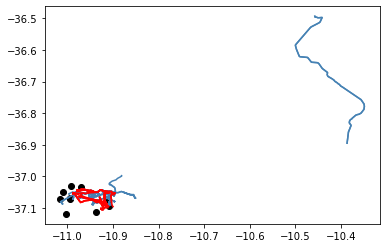

In [ ]:
# Choose Q

a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

m = 10
Q = np.ones((m,2))

Q[:,0] = 0.2 * (b - a ) * np.random.random_sample(m) + a - 0.01
Q[:,1] = 0.2 *(d - c ) * np.random.random_sample(m) + c - 0.02

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");
plt.scatter(Q[:,0], Q[:,1], color = "black")
print(colored(f'Original car-bus', 'yellow'))
plt.show()

In [ ]:
Q

array([[-10.90945666, -37.09542363],
       [-11.00322365, -37.11920292],
       [-11.00906333, -37.04903242],
       [-10.96945208, -37.03335838],
       [-11.01634769, -37.07260012],
       [-10.99461959, -37.07301607],
       [-10.99349658, -37.07038349],
       [-10.99274799, -37.03017237],
       [-10.91303942, -37.08081423],
       [-10.93733888, -37.11306223]])

In [ ]:
# Calculate distance matrix

path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44-|Q|=10.csv'
calculate_dists_d_Q_pi(cars, buses, p=1, path=path)

8.541507482528687

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44-|Q|=10.csv'
KNN_average_error_d_Q_pi(cars, buses, num_trials=50, path_to_dists=path)

num_trials = 50
total time = 1.112941026687622


(        Classifier  Train Error  Test Error     std
 1  KNN with d_Q_pi         0.16      0.2303  0.0585,
 0.16,
 0.23027027027027028,
 0.05852833592925044)

## Classification with Perceptron-Like algorithm (done)

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class (1).py


### Boost(MD $v_Q^{\exp}$) with epoch=50, maj_num=11 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT']:
    classif = classification(cars, buses, Q_size=10, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 653.7990958690643
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1149      0.2168     0.0558
mu = 0.02050842818010956
total time = 628.9809310436249
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0366      0.1578     0.0475
mu = 0.013912129066808276


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (ma

total time = 657.6852688789368
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0378        0.18     0.0574
mu = 0.00928107188951266
total time = 591.0637879371643
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1773     0.0709
mu = 0.012331413487341791


In [ ]:
for Model in ['RF', 'KNN', 'LR']:
    classif = classification(cars, buses, Q_size=10, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 1679.9625697135925
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.1616     0.0613
mu = 0.007190944608410632
total time = 529.538106918335
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1077      0.2184     0.0584
mu = 0.022713490081072152
total time = 521.318122625351
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2157      0.2773     0.0543
mu = 0.016113692326795714


### MD $v_Q^{\exp}$ with epoch=50, maj_num=1 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(cars, buses, Q_size=10, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 52.04708480834961
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1759      0.2811     0.0785
mu = 0.019325063713500512
total time = 55.09432053565979
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0453      0.1849     0.0732
mu = 0.022656812992245534


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (ma

total time = 56.34031820297241
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0484      0.2054     0.0804
mu = 0.006980649951755069
total time = 50.80660438537598
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree       0.0007      0.2319     0.0658
mu = 0.020284001138641372
total time = 175.3807249069214
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0022      0.1822     0.0599
mu = 0.00884656319873045
total time = 55.58487057685852
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1443      0.2486     0.0682
mu = 0.003723178845476127
total time = 55.638131618499756
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.2161        0.26     0.0543
mu = 0.018757770162414644


# |Q|=50

## Classification with feature mappings $v_Q$, $v_Q^{\exp}$, $v_Q^{\varsigma}$ with 10 random landmarks, and endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification (2).py


### Boost($v_Q$), Boost($v_Q^{\varsigma}$), Boost($v_Q^{\exp}$) with epoch=50 and num_trials_maj=11

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, epoch=50, 
                                    num_trials_maj=11, classifiers=clf,
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 131.99813270568848
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1470      0.2384     0.0716
2  Gaussian SVM, C=100, gamma=auto       0.0877      0.2027     0.0674
3  Poly kernel SVM, C=10, deg=auto       0.3214      0.3627     0.0416
4                    Decision Tree       0.0000      0.2097     0.0687
5     RandomForestClassifier, n=50       0.0000      0.1816     0.0623
6                              KNN       0.1639      0.2854     0.0678
7              Logistic Regression       0.3614      0.3805     0.0106
test_errors: 
 [0.2384, 0.2027, 0.3627, 0.2097, 0.1816, 0.2854, 0.3805]
std_test_errors: 
 [0.0716, 0.0674, 0.0416, 0.0687, 0.0623, 0.0678, 0.0106]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, 
                            epoch=50, num_trials_maj=11, classifiers=clf,
                            version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 228.6265630722046
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1251      0.3589     0.0694
2  Gaussian SVM, C=100, gamma=auto       0.0036      0.2243     0.0651
3  Poly kernel SVM, C=10, deg=auto       0.1747      0.3330     0.0591
4                    Decision Tree       0.0000      0.1778     0.0617
5     RandomForestClassifier, n=50       0.0000      0.1746     0.0605
6                              KNN       0.2178      0.3876     0.0670
7              Logistic Regression       0.3641      0.3881     0.0314
test_errors: 
 [0.3589, 0.2243, 0.333, 0.1778, 0.1746, 0.3876, 0.3881]
std_test_errors: 
 [0.0694, 0.0651, 0.0591, 0.0617, 0.0605, 0.067, 0.0314]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, epoch=50, 
                                num_trials_maj=11, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 158.71413040161133
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0957      0.2216     0.0772
2  Gaussian SVM, C=100, gamma=auto       0.0400      0.1946     0.0572
3  Poly kernel SVM, C=10, deg=auto       0.1227      0.2141     0.0518
4                    Decision Tree       0.0000      0.1995     0.0747
5     RandomForestClassifier, n=50       0.0000      0.1686     0.0634
6                              KNN       0.1400      0.2276     0.0637
7              Logistic Regression       0.2014      0.2405     0.0549
test_errors: 
 [0.2216, 0.1946, 0.2141, 0.1995, 0.1686, 0.2276, 0.2405]
std_test_errors: 
 [0.0772, 0.0572, 0.0518, 0.0747, 0.0634, 0.0637, 0.0549]


### Rand $v_Q$, Rand $v_Q^{\varsigma}$, Rand $v_Q^{\exp}$ with epoch=50 and num_trials_maj=1

In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='unsigned', test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 13.52392864227295
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1612      0.2292     0.0528
2  Gaussian SVM, C=100, gamma=auto       0.0981      0.1811     0.0511
3  Poly kernel SVM, C=10, deg=auto       0.3347      0.3616     0.0538
4                    Decision Tree       0.0000      0.2141     0.0688
5     RandomForestClassifier, n=50       0.0005      0.1670     0.0454
6                              KNN       0.1696      0.2481     0.0523
7              Logistic Regression       0.3614      0.3816     0.0128
test_errors: 
 [0.2292, 0.1811, 0.3616, 0.2141, 0.167, 0.2481, 0.3816]
std_test_errors: 
 [0.0528, 0.0511, 0.0538, 0.0688, 0.0454, 0.0523, 0.0128]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, 
                                    epoch=50, num_trials_maj=1, classifiers=clf, 
                                    version='signed', sigma=1, test_size=0.3)
A = classifs.classification_v_Q()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 32.08985137939453
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1573      0.4092     0.0781
2  Gaussian SVM, C=100, gamma=auto       0.0041      0.2405     0.0732
3  Poly kernel SVM, C=10, deg=auto       0.1942      0.3714     0.0400
4                    Decision Tree       0.0000      0.2114     0.0685
5     RandomForestClassifier, n=50       0.0000      0.1859     0.0561
6                              KNN       0.2292      0.3632     0.0686
7              Logistic Regression       0.3627      0.3886     0.0270
test_errors: 
 [0.4092, 0.2405, 0.3714, 0.2114, 0.1859, 0.3632, 0.3886]
std_test_errors: 
 [0.0781, 0.0732, 0.04, 0.0685, 0.0561, 0.0686, 0.027]


In [ ]:
classifs = binaryClassificationAverageMajority(cars, buses, Q_size=50, 
                    epoch=50, num_trials_maj=1, classifiers=clf, test_size=0.3)
A = classifs.classification_v_Q_mu()
print(A[0])
print('test_errors: \n', list(np.round(A[2], decimals=4)))
print('std_test_errors: \n', list(np.round(A[3], decimals=4)))

total time = 21.563114166259766
                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1096      0.2427     0.0632
2  Gaussian SVM, C=100, gamma=auto       0.0422      0.2000     0.0513
3  Poly kernel SVM, C=10, deg=auto       0.1280      0.2232     0.0569
4                    Decision Tree       0.0000      0.2114     0.0664
5     RandomForestClassifier, n=50       0.0012      0.1676     0.0562
6                              KNN       0.1569      0.2422     0.0698
7              Logistic Regression       0.2034      0.2557     0.0610
test_errors: 
 [0.2427, 0.2, 0.2232, 0.2114, 0.1676, 0.2422, 0.2557]
std_test_errors: 
 [0.0632, 0.0513, 0.0569, 0.0664, 0.0562, 0.0698, 0.061]


## KNN with $d_Q^{\pi}$ distance with |Q|=50

Original car-bus


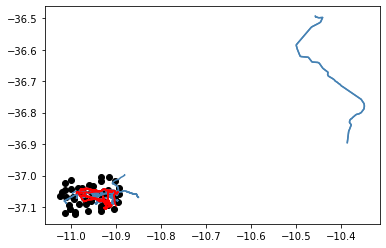

In [ ]:
# Choose Q

a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

m = 50
Q = np.ones((m,2))

Q[:,0] = 0.2 * (b - a ) * np.random.random_sample(m) + a - 0.01
Q[:,1] = 0.2 *(d - c ) * np.random.random_sample(m) + c - 0.02

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");
plt.scatter(Q[:,0], Q[:,1], color = "black")
print(colored(f'Original car-bus', 'yellow'))
plt.show()

In [ ]:
Q

array([[-10.97348037, -37.05308292],
       [-10.90485786, -37.10637263],
       [-11.02471258, -37.06589733],
       [-11.00465754, -37.09447187],
       [-10.97567565, -37.04117096],
       [-10.97131887, -37.07139129],
       [-10.91744548, -37.0468276 ],
       [-11.00277832, -37.10794003],
       [-10.93418819, -37.0735001 ],
       [-10.93459029, -37.00518304],
       [-10.8969977 , -37.0838866 ],
       [-10.99132785, -37.11634853],
       [-10.96648593, -37.08033495],
       [-10.93337645, -37.10241829],
       [-10.96123762, -37.03101242],
       [-10.98396238, -37.03991316],
       [-10.97575302, -37.04220276],
       [-10.99053422, -37.12215545],
       [-10.91787735, -37.05872022],
       [-10.89446546, -37.06006794],
       [-10.95694866, -37.07853308],
       [-11.01411515, -37.02336952],
       [-10.99966137, -37.01404585],
       [-10.93430893, -37.01655013],
       [-10.99377531, -37.07538503],
       [-10.90209895, -37.01589352],
       [-10.96294766, -37.11375283],
 

In [ ]:
# Calculate distance matrix

path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44-|Q|=50.csv'
calculate_dists_d_Q_pi(cars, buses, p=1, path=path)

21.315428495407104

In [ ]:
path = '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/d_Q_pi-76-44-|Q|=50.csv'
KNN_average_error_d_Q_pi(cars, buses, num_trials=50, path_to_dists=path)

num_trials = 50
total time = 0.9950101375579834


(        Classifier  Train Error  Test Error     std
 1  KNN with d_Q_pi       0.1554      0.2222  0.0605,
 0.15542168674698795,
 0.22216216216216222,
 0.060504332801885476)

## Classification with Perceptron-Like algorithm (done)

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class.py


### Boost(MD $v_Q^{\exp}$) with epoch=50, maj_num=11 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM']:
    classif = classification(cars, buses, Q_size=50, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 5343.986793041229
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0364      0.1784     0.0715
mu = 0.0016565774370462805
total time = 5243.363981485367
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto        0.034       0.153     0.0482
mu = 0.008827783934599154


In [ ]:
for Model in ['PSVM', 'DT']:
    classif = classification(cars, buses, Q_size=50, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (ma

total time = 4925.875552177429
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0354      0.1659     0.0644
mu = 0.021292809028423676
total time = 4706.526492357254
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1919     0.0711
mu = 0.022850963685714376


In [ ]:
classif = classification(cars, buses, Q_size=50, model='RF', C=100, gamma='auto', 
                        classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                        std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 10802.582311630249
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1676     0.0455
mu = 0.021367023726277523


In [ ]:
for Model in ['KNN', 'LR']:
    classif = classification(cars, buses, Q_size=50, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=11, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 4950.955623626709
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1294      0.2319     0.0524
mu = 0.013569459011707252
total time = 5123.112241744995
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1557      0.2324      0.064
mu = 0.023093128081983494


### MD $v_Q^{\exp}$ with epoch=50, maj_num=1 and init_iter=3 (done)

In [ ]:
for Model in ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR']:
    classif = classification(cars, buses, Q_size=50, model=Model, C=100, gamma='auto', 
                         classifiers=[], epoch=50, maj_num=1, init_iter=3, 
                         std_coeff=1, test_size=0.3, n_neighbors=5, n_estimators=50)

    A = classif.classification_Q()
    print(A[0])
    print(colored(f"mu = {A[1]}", 'blue'))
    print("===========================================================================")

total time = 415.3645839691162
               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0395      0.1865     0.0751
mu = 0.022262571542356113
total time = 402.69999170303345
                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto       0.0369      0.1595      0.059
mu = 0.005565617764618835


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (ma

total time = 399.43949365615845
                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto       0.0371      0.1914     0.0582
mu = 0.020502821338903132
total time = 386.31069231033325
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2032     0.0647
mu = 0.021124869262930446
total time = 965.2010746002197
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1724     0.0597
mu = 0.009340710050379286
total time = 414.52687072753906
  Classifier  Train Error  Test Error  Std Error
1        KNN        0.141      0.2476     0.0714
mu = 0.011825714153420819
total time = 415.0578999519348
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1889      0.2508     0.0684
mu = 0.001866543293935763


# Convolutional Neural Network For Random Choice of Q

## Helper functions

In [ ]:
from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))

In [ ]:
def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

In [ ]:
def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

In [ ]:
def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

In [ ]:
def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train, test, train_labels, test_labels

In [ ]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## Neural Network with Random $Q$

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train[0]))
        y_preds = torch.zeros(num_trials_maj, len(test[0]))

        Min = np.min([np.min(train[0][i], 0) for i in range(len(train[0]))], 0)
        Max = np.max([np.max(train[0][i], 0) for i in range(len(train[0]))], 0)
        Mean = np.mean([np.mean(train[0][i], 0) for i in range(len(train[0]))], 0)
        Std = np.std([np.std(train[0][i], 0) for i in range(len(train[0]))], 0)
        
        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train[0], version = version, sigma = sigma)
                test_data = curve2vec(Q, test[0], version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train[0], mu)
                test_data = ExpCurve2Vec(Q, test[0], mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train[0])
                test_data = get_endpoints(test[0])
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )

            #if torch.cuda.is_available(): # or device == torch.device("cuda:0"):
            #    model.cuda()
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels[0])
                losses[s, t, k] = loss
                    
                if (k+1) % 100 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 

            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels[0] - x_preds))/len(train_labels[0])
        test_errors[s] = sum(abs(test_labels[0] - y_preds))/len(test_labels[0])
            
    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf

### Endpoints

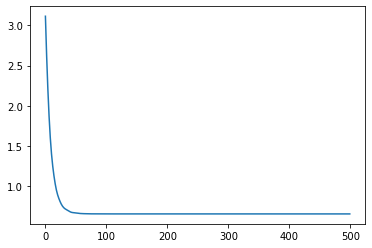

total time = 234.9255669116974


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.3614,0.3784,0.0


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 2,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'endpoints', 
                                   sigma = 1, test_size = 0.3)

### |Q|=10

### Majority = 11

#### Vote(Rand $v_Q$)

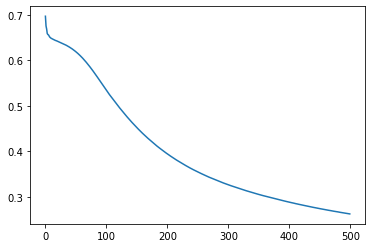

total time = 270.0492901802063


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.04,0.1145,0.2092,0.0809


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 4e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

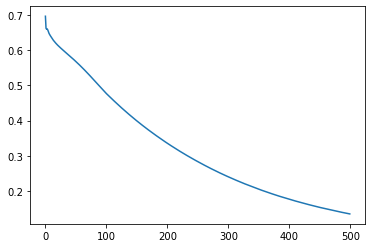

total time = 238.2826268672943


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0402,0.247,0.0673


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 2e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 1, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

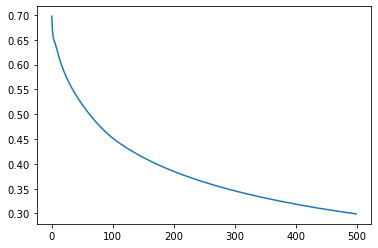

total time = 233.85604786872864


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1393,0.2481,0.0744


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### Majority = 1

#### Rand($v_Q$)

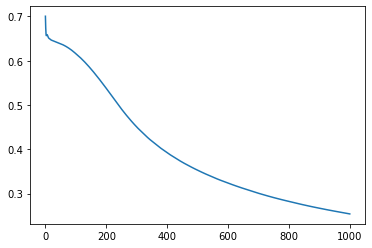

total time = 39.69449186325073


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1075,0.1908,0.0613


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

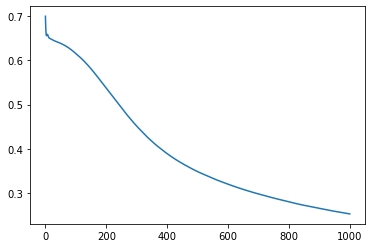

total time = 39.81338715553284


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1084,0.2049,0.0662


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{exp}$)

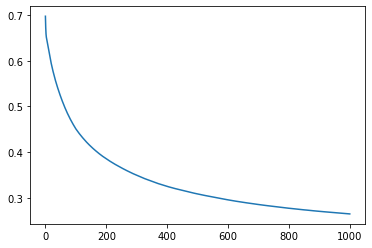

total time = 42.972105979919434


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1313,0.2443,0.0794


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 10, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### |Q|=20

### Majority = 11

#### Vote(Rand $v_Q$)

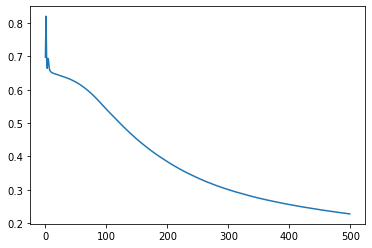

total time = 348.6723690032959


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.04,0.0928,0.1805,0.0576


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 4e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

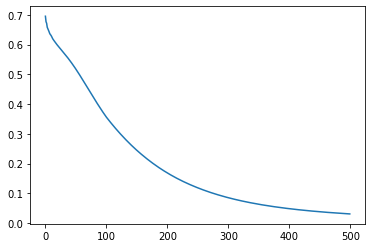

total time = 391.0437259674072


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0051,0.2503,0.08


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 2e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 1, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

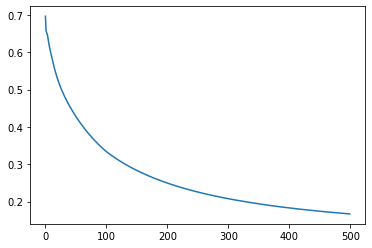

total time = 362.9685609340668


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0882,0.2032,0.0598


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### Majority = 1

#### Rand($v_Q$)

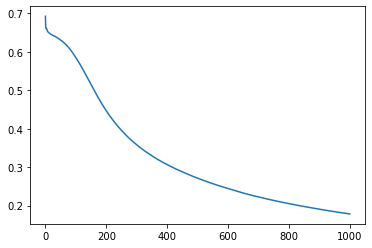

total time = 61.8660089969635


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0684,0.1881,0.0569


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

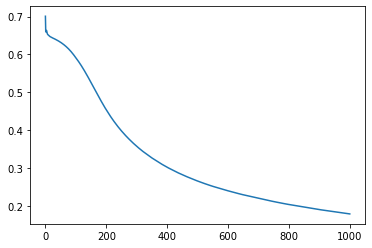

total time = 62.26603102684021


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0788,0.1778,0.0597


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{exp}$)

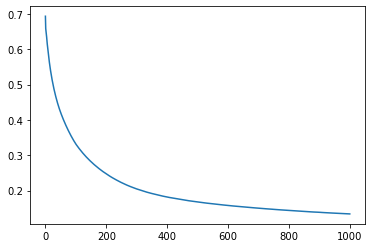

total time = 61.92973494529724


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0658,0.2168,0.0706


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### |Q|=30

### Majority = 11

#### Vote(Rand $v_Q$)

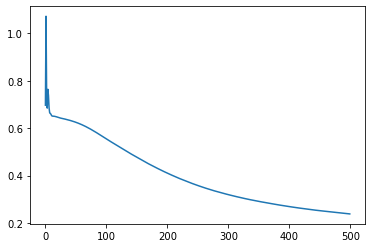

total time = 349.6482141017914


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.04,0.1104,0.2151,0.0735


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 4e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

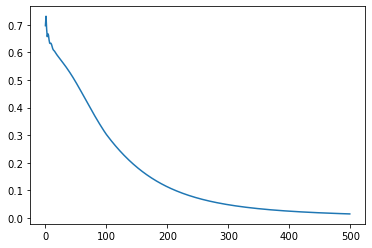

total time = 390.9503757953644


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0002,0.2843,0.0826


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 2e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 1, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

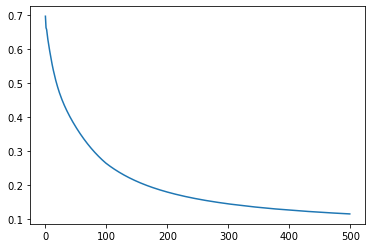

total time = 343.2012748718262


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0593,0.1995,0.0637


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### Majority = 1

#### Rand($v_Q$)

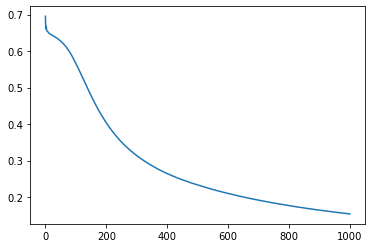

total time = 56.71244788169861


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.06,0.1638,0.05


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

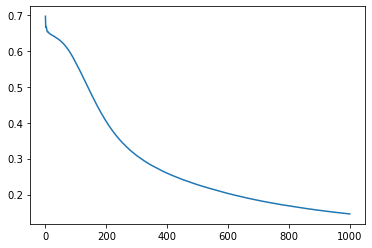

total time = 52.80774402618408


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0566,0.1714,0.062


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{exp}$)

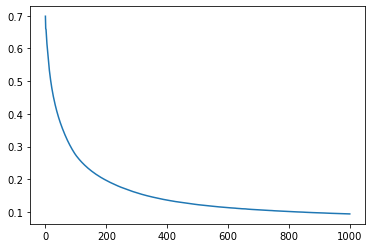

total time = 60.333970069885254


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0446,0.2065,0.065


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 30, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### |Q|=40

### Majority = 11

#### Vote(Rand $v_Q$)

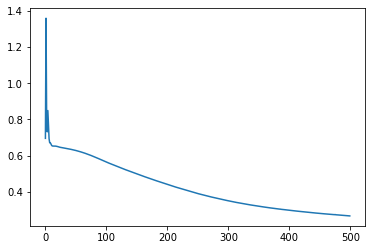

total time = 389.70406103134155


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.04,0.1169,0.1978,0.0815


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 4e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

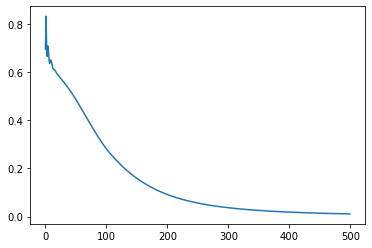

total time = 486.7439420223236


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.0,0.2422,0.0709


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 2e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 1, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

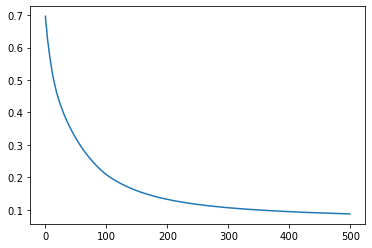

total time = 432.8305358886719


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0417,0.1897,0.0706


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### Majority = 1

#### Rand($v_Q$)

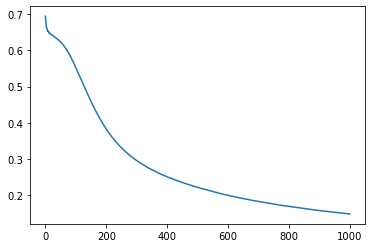

total time = 65.75947093963623


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0612,0.153,0.0539


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

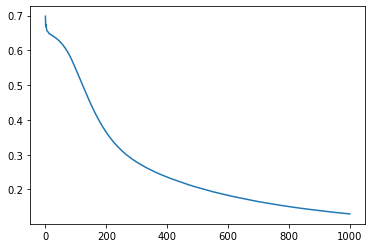

total time = 63.332764863967896


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0513,0.1686,0.0636


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{exp}$)

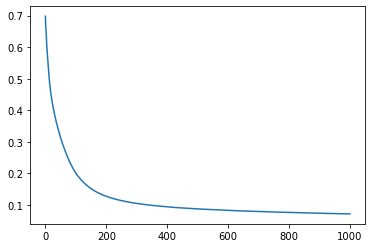

total time = 71.81149196624756


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0369,0.1784,0.0651


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 40, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### |Q| = 50

### Majority = 11

#### Vote(Rand $v_Q$)

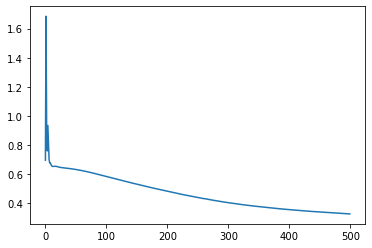

total time = 422.718633890152


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.04,0.153,0.2162,0.1089


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 4e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

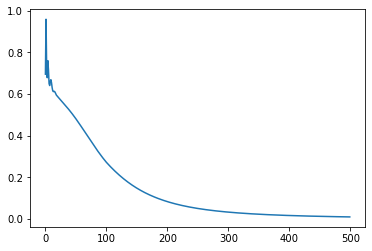

total time = 420.37779998779297


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.02,0.001,0.2557,0.0711


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 2e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 1, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

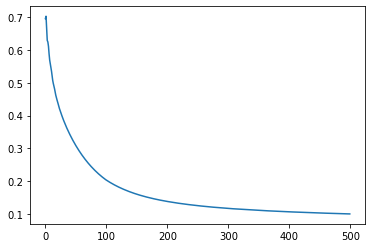

total time = 360.95970392227173


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0487,0.2146,0.0759


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

### Majority = 1

#### Rand($v_Q$)

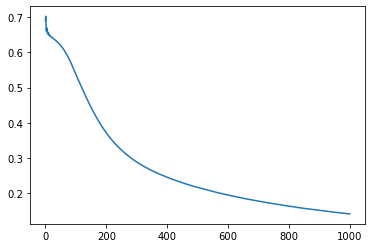

total time = 58.8238799571991


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0554,0.1654,0.0613


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

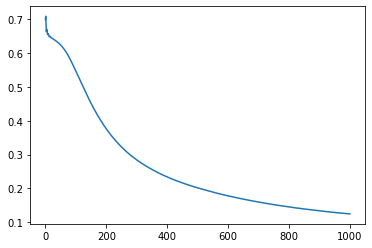

total time = 62.50993895530701


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0465,0.1757,0.0649


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3)

#### Rand($v_Q^{exp}$)

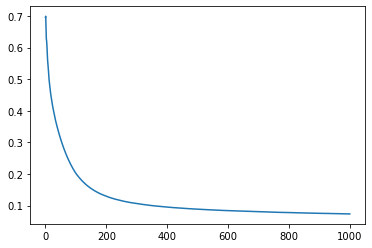

total time = 69.36460208892822


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0369,0.1859,0.065


In [ ]:
neuralNetworkClassificationCNN(cars, buses, Q_size = 50, lr_decay = 0.9, 
                                   learning_rate = 1e-2, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 1, test_size = 0.3)

# Neural Network for Mistake Driven Method of Choosing Q

## Initialize Q

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error

In [ ]:
# Example
initialize_Q(cars, buses, std_coeff=1, out_channels=10, kernel_size=5, 
             Q_size=20, padding=1, learning_rate = 1e-2, bias = True, D_out = 2, 
             lr_decay = 0.9, Num_updates = 100)

(array([[-10.93232142, -37.04901423],
        [-10.92422391, -37.02631216],
        [-10.9110082 , -37.05017516],
        [-10.92814798, -37.04916759],
        [-10.92742084, -37.0339235 ],
        [-10.97048725, -37.05567196],
        [-10.93737774, -37.06256902],
        [-10.93723373, -37.10190946],
        [-10.97778694, -37.04881682],
        [-10.93446373, -37.05118316],
        [-10.93859814, -37.03806488],
        [-10.97374032, -37.03916931],
        [-10.92494865, -37.0804357 ],
        [-10.89048916, -37.06415988],
        [-10.962987  , -37.0620349 ],
        [-10.90971331, -37.03651679],
        [-10.9007269 , -37.04651187],
        [-10.92903305, -37.05305364],
        [-10.89945443, -37.07147119],
        [-10.97678813, -37.04120758]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0.013263931892211644,
 0)

## Mistake Driven with CNN

In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = np.zeros((maj_num, len(train)))
        y_preds = np.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    #nn.LeakyReLU(0.01),
                    #nn.Tanh(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1).detach().numpy()
            y_preds[t] = torch.argmax(model(test_data), axis=1).detach().numpy()

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf

## With num_maj =11

In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 10, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 100)

total time = 1102.528389453888
mu = 0.02448062337309409


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.1349,0.2189,0.0603


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 20, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 100)

total time = 3300.6465454101562
mu = 0.02094225243041592


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0689,0.2081,0.0709


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 30, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 100)

total time = 5098.029304265976
mu = 0.011772677560156097


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0636,0.1822,0.0613


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 40, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 100)

total time = 7712.840994119644
mu = 0.003822515955951289


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0549,0.1659,0.0642


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=11, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 50, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 100)

total time = 12883.44871377945
mu = 0.0097494711599726


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.041,0.1719,0.0561


## With num_maj =1

In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=1, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 10, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

total time = 121.83530402183533
mu = 0.02504560648159071


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0894,0.2222,0.0892


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=1, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 20, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

total time = 342.98446893692017
mu = 0.021697586272507507


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0653,0.2038,0.078


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=1, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 30, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


total time = 529.4254531860352
mu = 0.01577352896213391


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0443,0.1935,0.0608


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=1, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 40, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

total time = 692.388580083847
mu = 0.010393092230621903


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0465,0.1951,0.0806


In [ ]:
MD_NeuralNetworkClassificationCNN(cars, buses, maj_num=1, epoch=50, init_iter=3, 
                                  test_size=0.3, std_coeff=1, out_channels=10, 
                                  kernel_size = 5, Q_size = 50, padding = 1, 
                                  learning_rate = 1e-2, bias = True, D_out=2, 
                                  lr_decay = 0.9, Num_updates = 1000)

total time = 1049.7853779792786
mu = 0.02238648994687331


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0376,0.2092,0.0635


## Adding physical features

### Only Physical features

In [ ]:
def CNN_classification_physical_features(data_1, data_2, lr_decay = 0.9, 
                                learning_rate = 1e-3, out_channels = 10, kernel_size = 10,
                                padding = 1, bias = True, Num_updates = 1000, D_out = 2, 
                                epoch = 50, sigma = 1, Leng=True, spd=True, accn=True, 
                                jrk=True, test_size=0.3):
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """
        
    start_time = time.time()
    
    train_errors = np.ones(epoch) 
    test_errors = np.ones(epoch)
    losses = torch.zeros(epoch, Num_updates)

    data = get_features(data_1, data_2, Leng=Leng, spd=spd, accn=accn, jrk=jrk)
    data1 = data[:len(data_1)]
    data2 = data[len(data_1):]

    for s in range(epoch):
        train_idx_1, test_idx_1, train_labels_1, test_labels_1, \
            train_idx_2, test_idx_2, train_labels_2, test_labels_2 \
                = train_test(data1, data2, test_size=test_size)

        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]

        I = np.arange(len(train1) + len(train2))
        np.random.shuffle(I)
        J = np.arange(len(test1) + len(test2))
        np.random.shuffle(J)

        train = np.concatenate((train1, train2), 0)[I]
        test = np.concatenate((test1, test2), 0)[J]
        train_labels = np.concatenate((train_labels_1, train_labels_2), 0)[I]
        test_labels = np.concatenate((test_labels_1, test_labels_2), 0)[J]
        
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        train = torch.from_numpy(train).float()
        test = torch.from_numpy(test).float()

        train = train.view(len(train), 1, len(train[0]))
        
        for k in range(Num_updates):
            x_pred = model(train) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[s, k] = loss

            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 
        
        x_preds = torch.argmax(model(train), axis=1)
        test = test.view(len(test), 1, len(test[0]))        
        y_preds = torch.argmax(model(test), axis=1)
        
        train_errors[s] = sum(abs(train_labels - x_preds)).detach().numpy()/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds)).detach().numpy()/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN": [np.round(train_error_mean, decimals=4), 
                    np.round(test_error_mean, decimals=4),
                    np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index',
                                 columns = ['Train Error', 'Test Error', 'Std Error'])
    
    plt.plot(losses[-1].detach().numpy())
    plt.show()
        
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

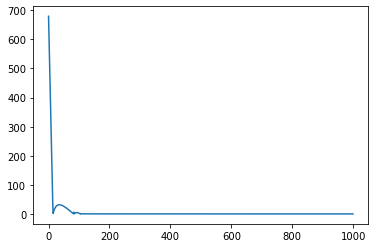

total time = 41.27839493751526


,Train Error,Test Error,Std Error
CNN,0.019,0.0503,0.0397


In [ ]:
CNN_classification_physical_features(cars_time, buses_time, lr_decay = 0.9, 
                                learning_rate = 1e-3, out_channels = 10, kernel_size = 2,
                                padding = 1, bias = True, Num_updates = 1000, D_out = 2, 
                                epoch = 50, sigma = 1, Leng=True, spd=True, accn=True, 
                                jrk=True, test_size=0.3)

## CNN with $v_Q^+$, $v_Q^{\varsigma+}$, $v_Q^{exp+}$ which are random Q and physical features

In [ ]:
def get_features_Q(train_1, train_2, version='unsigned', sigma=1, Q_size=20, 
                   Leng=True, spd=True, accn=True, jrk=True):

    train = np.concatenate((train_1, train_2), 0)
    n = len(train)
    train_traj_1 = np.array([train_1[i][:,:2] for i in range(len(train_1))])
    train_traj_2 = np.array([train_2[i][:,:2] for i in range(len(train_2))])
    train_traj = np.array([train[i][:,:2] for i in range(n)])

    Mean = np.mean([np.mean(train_traj[i], 0) for i in range(n)], 0)
    Std = np.std([np.std(train_traj[i], 0) for i in range(n)], 0)
    Q = np.ones((Q_size,2))
    Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
    Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

    if version == 'exp':
        mu = get_mu(train_traj_1, train_traj_2)
        A = ExpCurve2Vec(Q, train_traj, mu)
    else:
        A = np.array(curve2vec(Q, train_traj, version=version, sigma=sigma))
    
    if Leng == True:
        length_ = np.array([length(train_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A, Q

In [ ]:
def get_test_data_Q(test_1, test_2, Q, version='unsigned', sigma=1, Leng=True, 
                    spd=True, accn=True, jrk=True):

    test = np.concatenate((test_1, test_2), 0)
    n = len(test)
    test_traj_1 = np.array([test_1[i][:,:2] for i in range(len(test_1))])
    test_traj_2 = np.array([test_2[i][:,:2] for i in range(len(test_2))])
    test_traj = np.array([test[i][:,:2] for i in range(n)])
    
    if version == 'exp':
        mu = get_mu(test_traj_1, test_traj_2)
        A = ExpCurve2Vec(Q, test_traj, mu)
    else:
        A = np.array(curve2vec(Q, test_traj, version=version, sigma=sigma))
    
    if Leng == True:
        length_ = np.array([length(test_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(test[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A

In [ ]:
def CNN_classification_Q_physics(data1, data2, version='unsigned', sigma=1, Q_size=20, 
                             Leng=True, spd=True, accn=True, jrk=True, 
                             lr_decay = 0.9, learning_rate = 1e-3, out_channels = 10, 
                             kernel_size = 5, padding = 1, bias = True, 
                             Num_updates = 1000, D_out = 2, epoch = 50, test_size=0.3):

    start_time = time.time()
    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)
    losses = torch.zeros(epoch, Num_updates)

    for s in range(epoch):

        train_idx_1, test_idx_1, train_labels_1, test_labels_1, \
            train_idx_2, test_idx_2, train_labels_2, test_labels_2 \
            = train_test(data1, data2, test_size)

        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]

        train, Q = get_features_Q(train1, train2, version, sigma,
                                  Q_size, Leng, spd, accn, jrk)
        
        train_labels = np.concatenate((train_labels_1, train_labels_2), 0)

        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        train_labels = torch.from_numpy(train_labels).long()

        J = np.arange(len(test1)+len(test2))
        np.random.shuffle(J)

        test = get_test_data_Q(test1, test2, Q, version=version, sigma=sigma, 
                               Leng=Leng, spd=spd, accn=accn, jrk=jrk)[J]
        test_labels = np.concatenate((test_labels_1, test_labels_2), 0)[J]
        test_labels = torch.from_numpy(test_labels).long()

        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        train = torch.from_numpy(train).float()
        test = torch.from_numpy(test).float()

        train = train.view(len(train), 1, len(train[0]))
        
        for k in range(Num_updates):
            x_pred = model(train) # of shape (N, D_out)
            #print(x_pred, train_labels)
            #print(x_pred.shape, train_labels.shape)
            loss = loss_fn(x_pred, train_labels)
            losses[s, k] = loss

            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 

        x_preds = torch.argmax(model(train), axis=1)
        test = test.view(len(test), 1, len(test[0]))        
        y_preds = torch.argmax(model(test), axis=1)
        
        train_errors[s] = sum(abs(train_labels - x_preds)).detach().numpy()/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds)).detach().numpy()/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN": [np.round(train_error_mean, decimals=4), 
                    np.round(test_error_mean, decimals=4),
                    np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index',
                                 columns = ['Train Error', 'Test Error', 'Std Error'])
    
    plt.plot(losses[-1].detach().numpy())
    plt.show()
        
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf

## $v_Q^+$

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mus

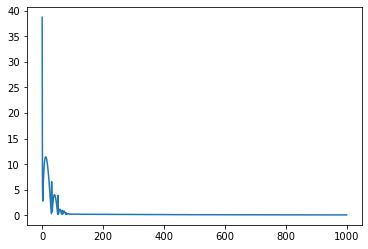

total time = 56.05419683456421


,Train Error,Test Error,Std Error
CNN,0.0169,0.0497,0.0395


In [ ]:
CNN_classification_Q_physics(cars_time, buses_time, version='unsigned', sigma=1, 
                             Q_size=20, Leng=True, spd=True, accn=True, jrk=True, 
                             lr_decay = 0.9, learning_rate = 1e-3, out_channels = 10, 
                             kernel_size = 5, padding = 1, bias = True, 
                             Num_updates = 1000, D_out = 2, epoch = 50, test_size=0.3)

## $v_Q^{\varsigma+}$

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mus

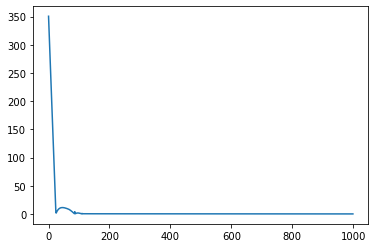

total time = 58.55793905258179


,Train Error,Test Error,Std Error
CNN,0.0046,0.0432,0.0354


In [ ]:
CNN_classification_Q_physics(cars_time, buses_time, version='signed', sigma=1, 
                             Q_size=20, Leng=True, spd=True, accn=True, jrk=True, 
                             lr_decay = 0.9, learning_rate = 1e-3, out_channels = 10, 
                             kernel_size = 5, padding = 1, bias = True, 
                             Num_updates = 1000, D_out = 2, epoch = 50, test_size=0.3)

## Using Perceptron-like algorithm with physical features

In [ ]:
#
def initialize_Q_(train_1, train_2, Q_size, mu_coeff, out_channels, kernel_size, padding, 
             learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, Leng=True, 
             spd=True, accn=True, jrk=True, Num_updates = 100):
    
    start_time = time.time()
    train = np.concatenate((train_1, train_2), 0)
    n = len(train)
    train_traj_1 = np.array([train_1[i][:,:2] for i in range(len(train_1))])
    train_traj_2 = np.array([train_2[i][:,:2] for i in range(len(train_2))])
    train_traj = np.array([train[i][:,:2] for i in range(n)])
    train_labels = np.array([1] * len(train_1) + [-1] * len(train_2))
    
    A = train_labels.copy().reshape(-1,1)
    if Leng == True:
        length_ = np.array([length(train_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(train[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)
    
    train_labels = torch.from_numpy(train_labels).long()

# Make the classifier
    
    mu = get_mu(train_traj_1, train_traj_2) * mu_coeff
    std = mu/2
    errors = []
    Q = []

    if sum([Leng, spd, accn, jrk]) > 0:
        Train_0 = A[:,1:]
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                Flatten(),
                                nn.Linear(out_channels * (len(Train_0[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
        
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        Train_0 = torch.from_numpy(Train_0).float() # shape = (120, 4)
        Train_0 = Train_0.view(len(Train_0), 1, len(Train_0[0]))
        
        for k in range(Num_updates):
            x_pred = model(Train_0) # of shape (N, D_out)
            #print(x_pred, train_labels)
            #print(x_pred.shape, train_labels.shape)
            loss = loss_fn(x_pred, train_labels)
            

            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()
            loss.backward() # Backward pass
            optimizer.step()  # Calling the step function on the Optimizer 
        print("*")
        #x_preds = torch.argmax(model(train), axis=1)
        index = torch.argmax(torch.max(model(train), axis=1))
        print(index)

        #train_error = sum(abs(train_labels - x_preds)).detach().numpy()/len(train_labels)    
        #errors.append(train_error) 
        
        #if model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
        #    index = np.argmax(np.max(Model.decision_function(Train_0)))
        #else:
        #    probs = Model.predict_proba(Train_0)
        #    index = np.argmax(entropy(probs, axis=1))
    else:
        index = np.random.randint(0, high=n) 
    k = np.random.randint(0, high=len(train_traj[index]))
    q = train_traj[index][k] + np.random.normal(0, std, 2)
    Q.append(q)
    print(Q)

# Iteratively choose landmarks
    for i in range(1, Q_size):
        if sum([Leng, spd, accn, jrk]) > 0:
            Train_0 = A[:,1:]
            Train = np.concatenate((Train_0, np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))), 1)
        else:
            Train = np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))

        Model.fit(Train, train_labels)
        train_pred = Model.predict(Train)
        error = 1 - metrics.accuracy_score(train_labels, train_pred)
        errors.append(error)
        if model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
            index = np.argmax(np.max(Model.decision_function(Train)))
        else:
            probs = Model.predict_proba(Train)
            index = np.argmax(entropy(probs, axis=1))

        k = np.random.randint(0, high=len(train_traj[index]))
        q = train_traj[index][k] + np.random.normal(0, std, 2)
        Q.append(q)
    if sum([Leng, spd, accn, jrk]) > 0:
        Train = np.concatenate((Train_0, np.array(ExpCurve2Vec(np.array(Q), train_traj, mu))), 1)
    else: 
        Train = ExpCurve2Vec(np.array(Q), train_traj, mu)
    Model.fit(Train, train_labels)
    train_pred = Model.predict(Train)

    error = 1 - metrics.accuracy_score(train_labels, train_pred)
    errors.append(error)

    print(colored(f"Total time for mapping row data: {time.time() - start_time}", 'green'))

    return np.array(Q), mu, np.array(errors), error


In [ ]:
def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

In [ ]:
def get_features_(data_time, Leng=True, spd=True, accn=True, jrk=True):
    
    n = len(data_time)
    data_traj = np.array([data_time[i][:,:2] for i in range(len(data_time))])
    data_labels = np.ones(n)
    A = data_labels.copy().reshape(-1,1)

    if Leng == True:
        length_ = np.array([length(data_traj[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, length_),1)
    if spd == True:
        speed_ = np.array([speed(data_time[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, speed_),1)
    if accn == True:
        acceleration_ = np.array([acceleration(data_time[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, acceleration_),1)
    if jrk == True:
        jerk_ = np.array([jerk(data_time[i]) for i in range(n)]).reshape(-1,1)
        A = np.concatenate((A, jerk_),1)

    return A[:, 1:]

In [ ]:
def MD_Pys_NeuralNetworkClassificationCNN(data_1_time, data_2_time, 
                                          maj_num, epoch, init_iter, std_coeff, 
                                          out_channels, kernel_size, Q_size, padding, 
                                          learning_rate=1e-3, bias=True, D_out=2, 
                                          lr_decay=0.9, test_size=0.3, Num_updates=100, 
                                          Leng=True, spd=True, accn=True, jrk=True):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)
    
    data_1 = np.array([data_1_time[i][:,:2] for i in range(len(data_1_time))])
    data_2 = np.array([data_2_time[i][:,:2] for i in range(len(data_2_time))])

    n_1 = len(data_1)
    n_2 = len(data_2) 
    
    data_1_phys = get_features_(data_1_time, Leng, spd, accn, jrk)
    data_2_phys = get_features_(data_2_time, Leng, spd, accn, jrk)
    
    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        data_phys_train = np.concatenate((data_1_phys[train_idx_1], data_2_phys[train_idx_2]), 0)
        data_phys_test = np.concatenate((data_1_phys[test_idx_1], data_2_phys[test_idx_2]), 0)
        
        x_preds = np.zeros((maj_num, len(train)))
        y_preds = np.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        data_phys_train = data_phys_train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        data_phys_test = data_phys_test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = np.concatenate((ExpCurve2Vec(Q, train, mu), data_phys_train), 1)
            train_data = torch.from_numpy(train_data).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = np.concatenate((ExpCurve2Vec(Q, test, mu), data_phys_test), 1)
            test_data = torch.from_numpy(test_data).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 50 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1).detach().numpy()
            y_preds[t] = torch.argmax(model(test_data), axis=1).detach().numpy()

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf

In [ ]:
MD_Pys_NeuralNetworkClassificationCNN(cars_time, buses_time, 
                                      maj_num=1, epoch=50, init_iter=3, 
                                      test_size=0.3, std_coeff=1, out_channels=10, 
                                      kernel_size=5, Q_size=10, padding=1, 
                                      learning_rate = 1e-2, bias = True, D_out=2, 
                                      lr_decay = 0.9, Num_updates = 1000)

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, 

total time = 106.7825129032135
mu = 0.008866339659107325


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0065,0.0395,0.0302


# Plot test errors

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_F$', r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

In [ ]:
A_LSVM = [0.1957, 0.2827, 0.4222, 0.2276, 0.2238, 0.2832, 0.4335, 0.2686, 0.4654]
A_GSVM = [0.1724, 0.1800, 0.2173, 0.1859, 0.1762, 0.2000, 0.2389, 0.2259, 0.2119]
A_PSVM = [0.1778, 0.3535, 0.3519, 0.2119, 0.1762, 0.3724, 0.3714, 0.2330, 0.2573]
A_DT = [0.1908, 0.1735, 0.1811, 0.1827, 0.2189, 0.2189, 0.2130, 0.2178, 0.1897]
A_RF = [0.1546, 0.1568, 0.1751, 0.1659, 0.1724, 0.1778, 0.1876, 0.1914, 0.1611]
A_KNN = [0.2292, 0.2497, 0.3395, 0.2265, 0.2530, 0.2643, 0.3443, 0.2476, 0.2481]
A_LR = [0.2427, 0.3795, 0.3795, 0.2773, 0.2573, 0.3784, 0.3805, 0.2881, 0.3784]
A_CNN = [0.2081, 0.1805, 0.2503, 0.2032, 0.2038, 0.1881, 0.1778, 0.2168, 0.3784]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0581, 0.0711, 0.0604, 0.0723, 0.0688, 0.0732, 0.0764, 0.0808, 0.0695]
std_GSVM = [0.0628, 0.0596, 0.0747, 0.0594, 0.0562, 0.0510, 0.0678, 0.0787, 0.0475]
std_PSVM = [0.0541, 0.0628, 0.0417, 0.0555, 0.0647, 0.0243, 0.0526, 0.0606, 0.0387]
std_DT = [0.0578, 0.0538, 0.0660, 0.0470, 0.0699, 0.0667, 0.0689, 0.0750, 0.0625]
std_RF = [0.0557, 0.0504, 0.0557, 0.0487, 0.0639, 0.0633, 0.0588, 0.0639, 0.0611]
std_KNN = [0.0649, 0.0586, 0.0924, 0.0690, 0.0644, 0.0568, 0.0837, 0.0697, 0.0556]
std_LR = [0.0427, 0.0076, 0.0053, 0.0474, 0.0555, 0.0000, 0.0091, 0.0613, 0.0000]
std_CNN = [0.0709, 0.0576, 0.0800, 0.0598, 0.0780, 0.0569, 0.0597, 0.0706, 0.0000]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
# test errors and stds for KNN
errors = [0.2573, 0.2557, 0.2405, 0.2589, 0.2535, 0.2438, 0.3022, 0.2200, 0.3124, 
          0.3335, 0.2968, 0.2514]

stds = [0.0633, 0.0642, 0.0663, 0.0682, 0.0698, 0.0702, 0.0677, 0.0465, 0.0774,
        0.0555, 0.0931, 0.0636]

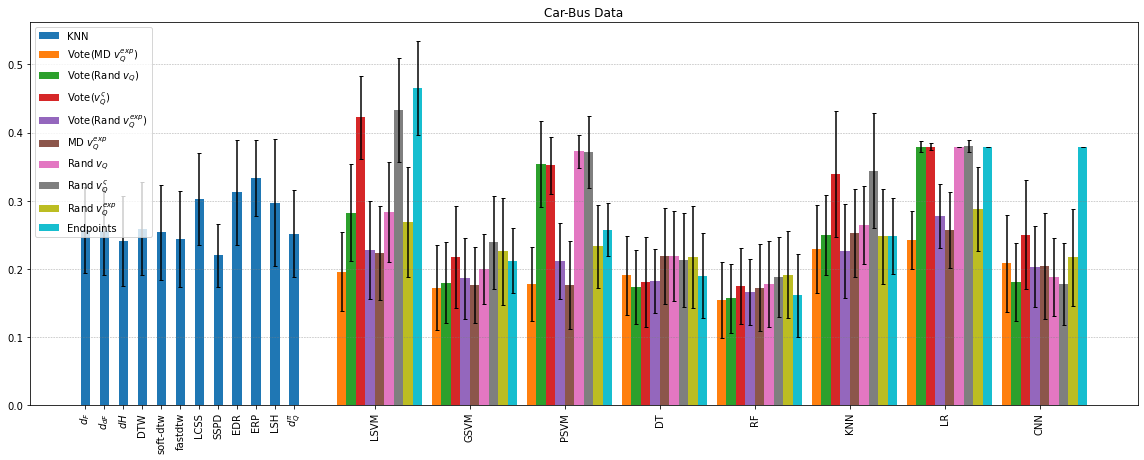

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (16, 6.5), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('Car-Bus Data')
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 10)

plt.legend(tuple(bars), FM, loc=0)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical')

path = '/content/gdrive/My Drive/plots/plots car-bus/car-bus bar chart all horizontal.csv'

plt.savefig(path, bbox_inches='tight', dpi=200)

plt.show()


# Plot of Physical feature mapping test errors

In [ ]:
A_LSVM = [0.0314, 0.0195, 0.0259, 0.0389]
A_GSVM = [0.0692, 0.0638, 0.0935, 0.0816]
A_PSVM = [0.3341, 0.1141, 0.1114, 0.0649]
A_DT = [0.0784, 0.0730, 0.0670, 0.0584]
A_RF = [0.0795, 0.0530, 0.0897, 0.0568]
A_KNN = [0.0773, 0.0870, 0.0832, 0.0870]
A_LR = [0.0465, 0.0384, 0.0432, 0.0519]
A_CNN = [0.0497, 0.0432, 0.0395, 0.0503]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0317, 0.0259, 0.0247, 0.0347]
std_GSVM = [0.0496, 0.0381, 0.0481, 0.0420]
std_PSVM = [0.0737, 0.0740, 0.0852, 0.0320]
std_DT = [0.0440, 0.0437, 0.0372, 0.0372]
std_RF = [0.0440, 0.0393, 0.0447, 0.0330]
std_KNN = [0.0412, 0.0460, 0.0445, 0.0409]
std_LR = [0.0367, 0.0383, 0.0394, 0.0370]
std_CNN = [0.0395, 0.0354, 0.0302, 0.0397]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

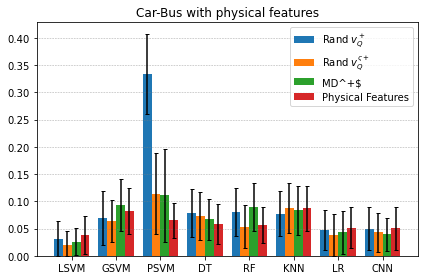

In [ ]:
FM = (r'Rand $v_Q^+$', r'Rand $v_Q^{\varsigma +}$', r'MD^+$', 'Physical Features')
labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

ind = np.arange(len(A))
width = 0.2
plt.subplots(figsize = (6, 4), tight_layout=True)
bars = [0] * 4

for i in range(len(FM)):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i] = plt.bar(ind+width*i, B[i], width, yerr=[lower_limit, C[i]], 
                       ecolor='black', capsize=2)

plt.title('Car-Bus with physical features')
plt.xticks(ind+1.5 * width, labels)
plt.legend(tuple(bars), FM, loc=0)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)

path = '/content/gdrive/My Drive/plots/plots car-bus-physical/Physical car-bus bar chart.csv'

plt.savefig(path, bbox_inches='tight', dpi=200)

plt.show()
